In [6]:
import csv
import datetime
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sp
import pandas as pd
import seaborn as sns
sns.set(font_scale=1.1)
sns.set_palette("bright")
import io
%pylab inline
pylab.rcParams['figure.figsize'] = (15,8)
# matplotlib.rcParams.update({'font.size': 18})

Populating the interactive namespace from numpy and matplotlib


/Users/maxfrenzel/py3.6/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
# Caffeine dictionary
caffeine_vals = {
    "Filter" : 115,
    "Espresso" : 70,
    "Coldbrew" : 150,
    "Green Tea (500ml)" : 60,
    "Green Tea (260ml)" : 30
}

# Read caffeine events from file, giving each event a time and a type
Events = []
with io.open("Caffeine.csv", "rt", encoding="utf8") as csvfile:
    
    reader = csv.reader(csvfile, delimiter=',', quotechar='"')
    
    header = next(reader)
    print(header)
    
    for row in reader:
        
        # Add up caffeine and store
        caffeine = 0
        for i in range(len(row)-2):
            if row[i+1] == '1':
                caffeine += caffeine_vals[header[i+1]]
            if row[-1] != '':
                caffeine += int(row[-1])
        
        Events.append([datetime.datetime.strptime(row[0], '%B %d, %Y %H:%M:%S %Z'), caffeine])

['timestamp', 'Filter', 'Espresso', 'Coldbrew', 'Green Tea (500ml)', 'Green Tea (260ml)', 'Caffeine (other)']


In [3]:
# ----------------------------------
# Model caffeine in blood

# Biological half life time of caffeine (in minutes)
half_life = 4*60.0
# Variance of Gaussian modelling caffeine entering bloodstream
sigma = 60

# Temporal resolution
resolution = 5
dt = datetime.timedelta(minutes=resolution)

# Decay factor
decay_factor = (0.5)**(resolution/half_life)

# Set starting time and initialise timestamp and caffeineLevel lists
t_start = Events[0][0]
# Make sure it starts on round minute
t_start = t_start.replace(minute=0,second=0)
time = t_start + dt

timestamps = [t_start]
caffeineLevel = [0]
    
event_index = 0

# List to store events until all their caffeine is in bloodstream
past_events = []
    
while time < (Events[-1][0] + datetime.timedelta(minutes=300)):
    
    new_caffeine_level = caffeineLevel[-1] * decay_factor

    if event_index < len(Events) and time > Events[event_index][0]:
            
        # Create Gaussian that will model caffeine entering bloodstream
        gaussian = [np.exp(-(k*resolution-30)**2/sigma) for k in range(25)]
        # Normalise
        gaussian = [x * Events[event_index][1]/sum(gaussian) for x in gaussian]

        # Add Gaussian to list of past events
        past_events.append(gaussian)
            
        event_index += 1
        
    # Add caffeine for all still outstanding past events
    add_caffeine = 0.0
    for c in past_events:
        add_caffeine += c[0]
        del c[0]
        # Remove event if this was the last entry
        if c == []:
            past_events.remove(c)
                    
    new_caffeine_level += add_caffeine
    
    caffeineLevel.append(new_caffeine_level)
    timestamps.append(time)
    #print new_caffeine_level
    
    time += dt

In [96]:
timestamps[-1].weekday()

5

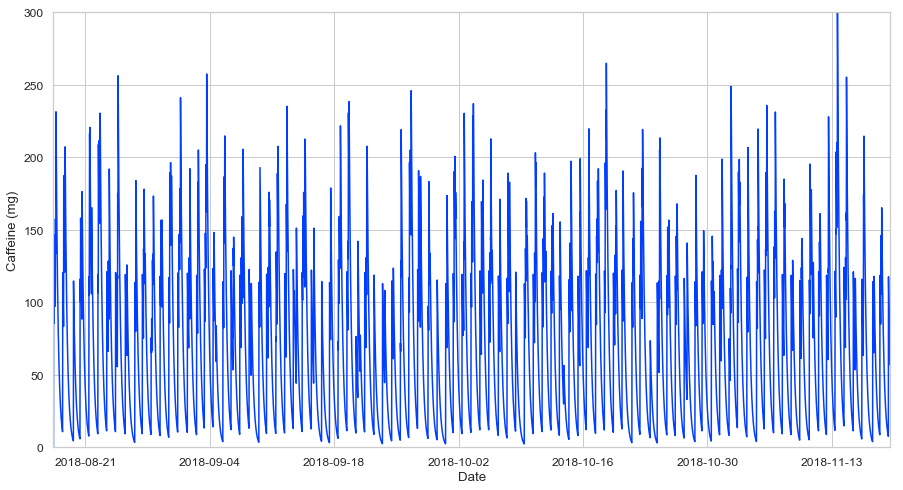

In [7]:
with sns.axes_style("whitegrid"):
    plt.plot(timestamps, caffeineLevel)
    plt.xlim([timestamps[0],timestamps[-1]])
    plt.xlabel('Date')
    plt.ylabel('Caffeine (mg)')
    plt.ylim([0,300])

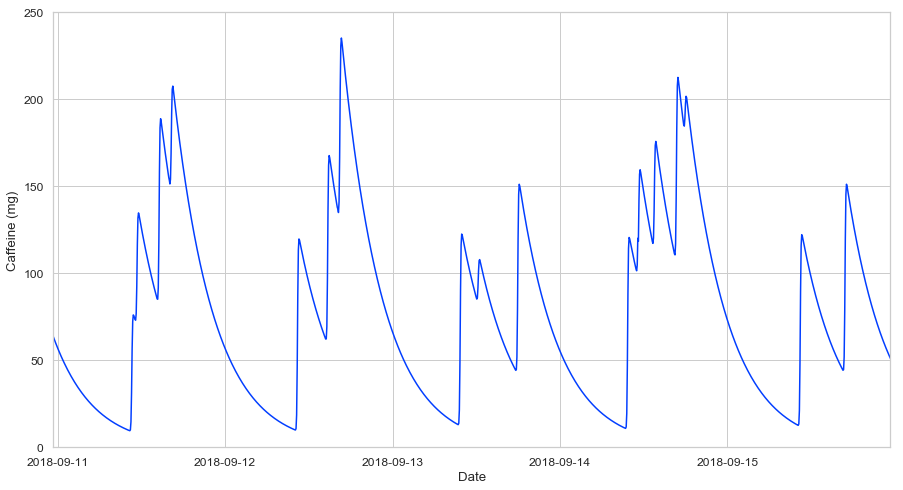

In [8]:
# zoomed in
start_index = int(24.6*(24*60)/resolution)
end_index = int(start_index + 5*(24*60)/resolution)

with sns.axes_style("whitegrid"):
    plt.plot(timestamps, caffeineLevel)
    plt.xlim([timestamps[start_index],timestamps[end_index]])
    plt.xlabel('Date')
    plt.ylabel('Caffeine (mg)')
    plt.ylim([0,250])

In [9]:
# Daily average
time = datetime.datetime(2018, 1, 1, 0, 0)

timestamps_average = [time]
caffeine_average = []
caffeine_average_weekday = []
caffeine_average_weekend = []

for k in range(int(1440/resolution)-1):
    time += dt
    timestamps_average.append(time)
    
# Total
for time in timestamps_average:
    # Times in total list
    occurences = [t for t in timestamps if t.time().replace(second=0) == time.time()]
    occurences_weekday = [t for t in occurences if t.weekday() not in [5,6]]
    occurences_weekend = [t for t in occurences if t.weekday() in [5,6]]
    caffeine_list = [caffeineLevel[timestamps.index(t)] for t in occurences]
    caffeine_list_weekday = [caffeineLevel[timestamps.index(t)] for t in occurences_weekday]
    caffeine_list_weekend = [caffeineLevel[timestamps.index(t)] for t in occurences_weekend]
    
    # Calculate averages
    if len(occurences) != 0:
        caffeine_average.append(sum(caffeine_list)/len(occurences))
    else:
        caffeine_average.append(0.0)
    if len(occurences_weekday) != 0:
        caffeine_average_weekday.append(sum(caffeine_list_weekday)/len(occurences_weekday))
    else:
        caffeine_average_weekday.append(0.0)
    if len(occurences_weekend) != 0:
        caffeine_average_weekend.append(sum(caffeine_list_weekend)/len(occurences_weekend))
    else:
        caffeine_average_weekend.append(0.0)
        
timestamps_average = [t.time() for t in timestamps_average]

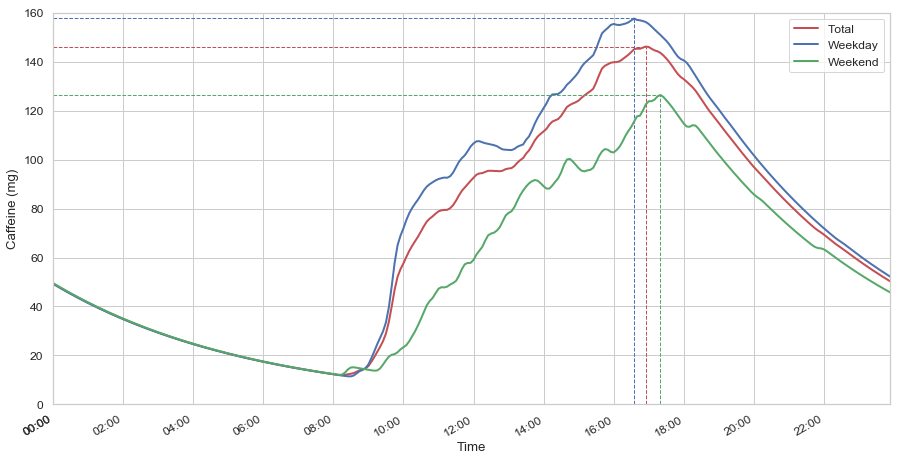

In [10]:
# Find maxima
max_index = caffeine_average.index(max(caffeine_average))
max_index_weekday = caffeine_average_weekday.index(max(caffeine_average_weekday))
max_index_weekend = caffeine_average_weekend.index(max(caffeine_average_weekend))

# Plot averages
with sns.axes_style("whitegrid"):
    xticks = [(datetime.datetime.combine(datetime.date.today(), timestamps_average[0]) + datetime.timedelta(hours=2*k)).time() for k in range(13)]
    
    plt.plot(timestamps_average, caffeine_average, label='Total', color='r', linewidth=2)
    plt.plot([timestamps_average[0],timestamps_average[max_index]], [caffeine_average[max_index],caffeine_average[max_index]], '--', color='r', linewidth=1)
    plt.plot([timestamps_average[max_index],timestamps_average[max_index]], [0.0,caffeine_average[max_index]], '--', color='r', linewidth=1)
    
    plt.plot(timestamps_average, caffeine_average_weekday, label='Weekday', color='b', linewidth=2)
    plt.plot([timestamps_average[0],timestamps_average[max_index_weekday]], [caffeine_average_weekday[max_index_weekday],caffeine_average_weekday[max_index_weekday]], '--', color='b', linewidth=1)
    plt.plot([timestamps_average[max_index_weekday],timestamps_average[max_index_weekday]], [0.0,caffeine_average_weekday[max_index_weekday]], '--', color='b', linewidth=1)
    
    plt.plot(timestamps_average, caffeine_average_weekend, label='Weekend', color='g', linewidth=2)
    plt.plot([timestamps_average[0],timestamps_average[max_index_weekend]], [caffeine_average_weekend[max_index_weekend],caffeine_average_weekend[max_index_weekend]], '--', color='g', linewidth=1)
    plt.plot([timestamps_average[max_index_weekend],timestamps_average[max_index_weekend]], [0.0,caffeine_average_weekend[max_index_weekend]], '--', color='g', linewidth=1)
    
    plt.xticks(xticks)
    plt.gcf().autofmt_xdate()
    plt.ylim([0,160])
    plt.xlim([0,24*60*60-400])
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Caffeine (mg)')

In [11]:
caffeine_average[max_index]

146.16661721792323

In [12]:
# Load alcohol and Oura data
alcohol_data = pd.read_csv("Alcohol.csv") 
oura_data = pd.read_csv("oura.csv") 

# Convert timestamps to date; Also shift alcohol timestamps by one since effect is on the following days Oura data
alcohol_data.timestamp = alcohol_data.timestamp.apply(lambda t : datetime.datetime.strptime(t, '%B %d, %Y %H:%M:%S %Z').date()+datetime.timedelta(days=1))
alcohol_data = alcohol_data.rename(index=str, columns={"timestamp": "date"})
oura_data.date = oura_data.date.apply(lambda t : datetime.datetime.strptime(t, '%Y-%m-%d').date())

# Turn alcohol into single column
alc_list = []
for k in range(len(alcohol_data)):
    if alcohol_data['None'][k] == 1.0:
        alc_list.append('None')
    elif alcohol_data['A bit'][k] == 1.0:
        alc_list.append('A bit')
    elif alcohol_data['Quite a bit'][k] == 1.0:
        alc_list.append('Quite a bit')
    elif alcohol_data['A lot'][k] == 1.0:
        alc_list.append('A lot')
    else:
        alc_list.append('Error')
alcohol_data['Alcohol'] = np.array(alc_list)
alcohol_data['Alcohol'] = alcohol_data['Alcohol'].astype('category')

# Merge datasets
dataframe = pd.merge(oura_data, alcohol_data.drop(labels=['None','A bit','Quite a bit','A lot'], axis=1), on='date')

In [13]:
# Function to find nearest (datetime) item from list
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

# Find caffeine at bedtime for each day
# Add new column to dataframe
dataframe['Bedtime Caffeine (mg)'] = np.zeros(len(dataframe))

bedtimes=[]
bedtimes_weekday=[]
bedtimes_weekend=[]
bt_caffeine=[]
bt_caffeine_weekday=[]
bt_caffeine_weekend=[]

alc_bedtimes = {
    'None':[],
    'A bit':[],
    'Quite a bit':[],
    'A lot':[]
}

for k in range(len(dataframe)):
    # Find relevant caffeine value
    bedtime = datetime.datetime.strptime(dataframe['Bedtime Start'][k], '%Y-%m-%dT%H:%M:%S+09:00')
    
    nearest_time = nearest(timestamps,bedtime)
    bedtime_caffeine = caffeineLevel[timestamps.index(nearest_time)]
    
    bedtimes.append(nearest_time)
    bt_caffeine.append(bedtime_caffeine)
    if nearest_time.weekday() in [5,6]:
        bedtimes_weekend.append(nearest_time)
        bt_caffeine_weekend.append(bedtime_caffeine)
    else:
        bedtimes_weekday.append(nearest_time)
        bt_caffeine_weekday.append(bedtime_caffeine)
        
    alc_bedtimes[dataframe['Alcohol'][k]].append(nearest_time)
        
    dataframe['Bedtime Caffeine (mg)'][k] = bedtime_caffeine
    
# Add columns for sleep ratios
dataframe['Deep Sleep Ratio'] = dataframe['Deep Sleep Time']/dataframe['Total Sleep Time']
dataframe['Light Sleep Ratio'] = dataframe['Light Sleep Time']/dataframe['Total Sleep Time']
dataframe['REM Sleep Ratio'] = dataframe['REM Sleep Time']/dataframe['Total Sleep Time']
dataframe['Awake Ratio'] = dataframe['Awake Time']/dataframe['Total Sleep Time']

len(dataframe)

/Users/maxfrenzel/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


91

In [14]:
# Find average bedtimes
def average_time(times):
    timestamps=[]
    for t in times:
        if t.hour > 12:
            timestamps.append(t.replace(year=2018,month=1,day=1).timestamp())
        else:
            timestamps.append(t.replace(year=2018,month=1,day=2).timestamp())
    average_timestamp = sum(timestamps)/len(timestamps)
    return datetime.datetime.fromtimestamp(average_timestamp).time()
    
# Find average bedtimes
bedtime_total = average_time(bedtimes)
bedtime_weekday = average_time(bedtimes_weekday)
bedtime_weekend = average_time(bedtimes_weekend)

av_bt_caffeine = sum(bt_caffeine)/len(bt_caffeine)
av_bt_caffeine_weekday = sum(bt_caffeine_weekday)/len(bt_caffeine_weekday)
av_bt_caffeine_weekend = sum(bt_caffeine_weekend)/len(bt_caffeine_weekend)

In [15]:
# Find average bedtimes across alcohol groups
alc_bedtimes_average={
    'None':average_time(alc_bedtimes['None']),
    'A bit':average_time(alc_bedtimes['A bit']),
    'Quite a bit':average_time(alc_bedtimes['Quite a bit']),
    'A lot':average_time(alc_bedtimes['A lot'])
}
alc_bedtimes_average

{'None': datetime.time(23, 45),
 'A bit': datetime.time(0, 5, 34, 615385),
 'Quite a bit': datetime.time(1, 41, 15),
 'A lot': datetime.time(3, 13, 53, 333333)}

In [16]:
def times_to_hours(times):
    hours = []
    not_list = True
    if type(times) != list:
        times = [times]
        not_list = False
    for t in times:
        if t.hour > 12:
            hours.append(-((24.0-t.hour) - (60-t.minute)/60) - (60-t.second)/(60**2))
        else:
            hours.append(t.hour + (60-t.minute)/60 + (60-t.second)/(60**2))
    
    if not_list:        
        return hours
    else:
        return hours[0]

# alc_bedtimes_hour={
#     'None':times_to_hours(alc_bedtimes['None']),
#     'A bit':times_to_hours(alc_bedtimes['A bit']),
#     'Quite a bit':times_to_hours(alc_bedtimes['Quite a bit']),
#     'A lot':times_to_hours(alc_bedtimes['A lot'])
# }
# alc_bedtimes_hour

# Add new column to dataframe
dataframe['Bedtime Hour'] = np.zeros(len(dataframe))

for k in range(len(dataframe)):
    dataframe['Bedtime Hour'][k] = times_to_hours(datetime.datetime.strptime(dataframe['Bedtime Start'][k], '%Y-%m-%dT%H:%M:%S+09:00'))

/Users/maxfrenzel/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [17]:
# Create groups for alcohol level and order
dataframe_grouped = dataframe.groupby('Alcohol')
dataframe_lowbooze = pd.concat([dataframe_grouped.get_group('None'),dataframe_grouped.get_group('A bit')])

dataframe['Alcohol'] = dataframe['Alcohol'].cat.reorder_categories(['None','A bit','Quite a bit','A lot'], ordered=True)

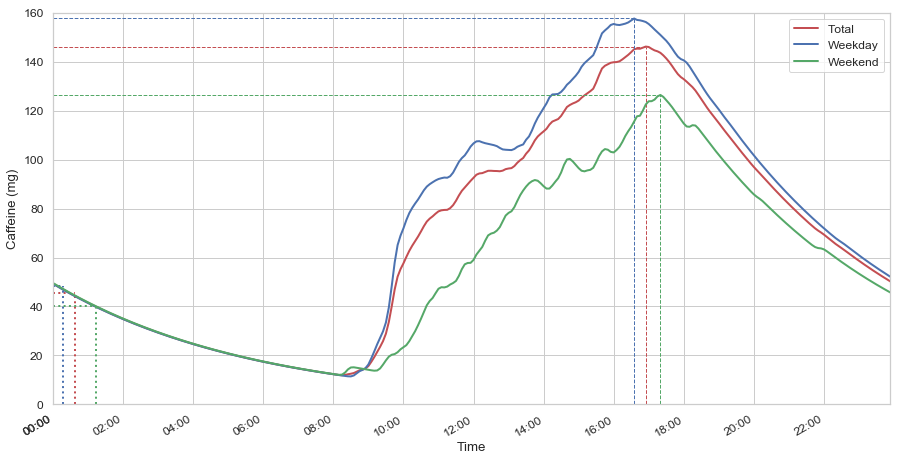

In [18]:
# Plot again with bed times

# Find maxima
max_index = caffeine_average.index(max(caffeine_average))
max_index_weekday = caffeine_average_weekday.index(max(caffeine_average_weekday))
max_index_weekend = caffeine_average_weekend.index(max(caffeine_average_weekend))

with sns.axes_style("whitegrid"):
    xticks = [(datetime.datetime.combine(datetime.date.today(), timestamps_average[0]) + datetime.timedelta(hours=2*k)).time() for k in range(13)]
    
    plt.plot(timestamps_average, caffeine_average, label='Total', color='r', linewidth=2)
    plt.plot([timestamps_average[0],timestamps_average[max_index]], [caffeine_average[max_index],caffeine_average[max_index]], '--', color='r', linewidth=1)
    plt.plot([timestamps_average[max_index],timestamps_average[max_index]], [0.0,caffeine_average[max_index]], '--', color='r', linewidth=1)
    plt.plot([timestamps_average[0],bedtime_total], [av_bt_caffeine,av_bt_caffeine], ':', color='r', linewidth=2)
    plt.plot([bedtime_total,bedtime_total], [0,av_bt_caffeine], ':', color='r', linewidth=2)
    
    plt.plot(timestamps_average, caffeine_average_weekday, label='Weekday', color='b', linewidth=2)
    plt.plot([timestamps_average[0],timestamps_average[max_index_weekday]], [caffeine_average_weekday[max_index_weekday],caffeine_average_weekday[max_index_weekday]], '--', color='b', linewidth=1)
    plt.plot([timestamps_average[max_index_weekday],timestamps_average[max_index_weekday]], [0.0,caffeine_average_weekday[max_index_weekday]], '--', color='b', linewidth=1)
    plt.plot([timestamps_average[0],bedtime_weekday], [av_bt_caffeine_weekday,av_bt_caffeine_weekday], ':', color='b', linewidth=2)
    plt.plot([bedtime_weekday,bedtime_weekday], [0,av_bt_caffeine_weekday], ':', color='b', linewidth=2)
    
    plt.plot(timestamps_average, caffeine_average_weekend, label='Weekend', color='g', linewidth=2)
    plt.plot([timestamps_average[0],timestamps_average[max_index_weekend]], [caffeine_average_weekend[max_index_weekend],caffeine_average_weekend[max_index_weekend]], '--', color='g', linewidth=1)
    plt.plot([timestamps_average[max_index_weekend],timestamps_average[max_index_weekend]], [0.0,caffeine_average_weekend[max_index_weekend]], '--', color='g', linewidth=1)
    plt.plot([timestamps_average[0],bedtime_weekend], [av_bt_caffeine_weekend,av_bt_caffeine_weekend], ':', color='g', linewidth=2)
    plt.plot([bedtime_weekend,bedtime_weekend], [0,av_bt_caffeine_weekend], ':', color='g', linewidth=2)
    
    plt.xticks(xticks)
    plt.gcf().autofmt_xdate()
    plt.ylim([0,160])
    plt.xlim([0,24*60*60-400])
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Caffeine (mg)')

In [19]:
dataframe.corr()

Sleep Score  Total Sleep Score  REM Sleep Score  \
Sleep Score                     1.000000           0.903349         0.587683   
Total Sleep Score               0.903349           1.000000         0.456806   
REM Sleep Score                 0.587683           0.456806         1.000000   
Deep Sleep Score                0.543112           0.397649         0.125214   
Sleep Efficiency Score          0.468864           0.249266         0.194464   
Sleep Tranquility Score         0.274061           0.059142         0.101597   
Sleep Latency Score             0.203455           0.151395        -0.073533   
Sleep Timing Score              0.521109           0.327934         0.009315   
Total Bedtime                   0.712204           0.891729         0.400064   
Total Sleep Time                0.887734           0.969464         0.472880   
Awake Time                     -0.295608          -0.051407        -0.108197   
REM Sleep Time                  0.584924           0.501652         0.885707   
Light Sleep Time                0.300476           0.550005        -0.272813   
Deep Sleep Time                 0.633156           0.552399         0.204517   
Restless Sleep                  0.141401           0.196960         0.070115   
Sleep Efficiency                0.440737           0.227077         0.203499   
Sleep Latency                   0.264566           0.342053        -0.017214   
Sleep Timing                    0.696171           0.880000         0.370733   
Sleep Timing.1                       NaN                NaN              NaN   
Average Resting Heart Rate     -0.666288          -0.655195        -0.123158   
Lowest Resting Heart Rate      -0.679106          -0.680718        -0.166055   
Average HRV                     0.686509           0.680339         0.132876   
Temperature Deviation          -0.172160          -0.092891        -0.102782   
Respiratory Rate               -0.302697          -0.182825        -0.155823   
Activity Score                 -0.048660          -0.042408        -0.058262   
Stay Active Score               0.032287           0.069250         0.231468   
Move Every Hour Score           0.022446           0.044614         0.049510   
Meet Daily Targets Score       -0.077213          -0.108283        -0.060367   
Training Frequency Score             NaN                NaN              NaN   
Training Volume Score           0.133612           0.138877        -0.035525   
Recovery Time Score            -0.025308          -0.010673        -0.068216   
Activity Burn                   0.175659           0.118254        -0.093814   
Total Burn                      0.160785           0.106956        -0.118986   
Target Calories                 0.819704           0.775919         0.334288   
Steps                          -0.091621          -0.103649        -0.136866   
Daily Movement                  0.112967           0.060546        -0.121718   
Inactive Time                   0.011336           0.000318        -0.162273   
Rest Time                      -0.228331          -0.188433         0.139426   
Low Activity Time              -0.080066          -0.081980        -0.159934   
Medium Activity Time           -0.174635          -0.197334        -0.192524   
High Activity Time              0.359084           0.295161         0.086550   
Non-wear Time                   0.114999           0.152079         0.076341   
Average MET                     0.179564           0.125311        -0.123091   
Long Periods of Inactivity     -0.022446          -0.044614        -0.049510   
Readiness Score                 0.857644           0.826255         0.333642   
Previous Night Score            0.991040           0.902578         0.584361   
Sleep Balance Score             0.418662           0.521165         0.049594   
Previous Day Activity Score     0.113493           0.087313         0.149747   
Activity Balance Score          0.047455           0.033698        -0.002920   
Temperature Score            

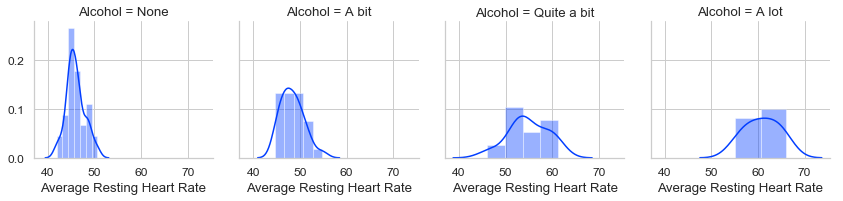

In [20]:
sns.set(font_scale=1.1)
sns.set_palette("bright")
with sns.axes_style("whitegrid"):
    g = sns.FacetGrid(dataframe, col='Alcohol')
    g.map(sns.distplot, "Average Resting Heart Rate")

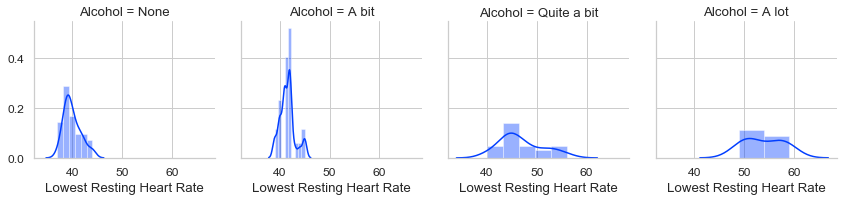

In [21]:
sns.set(font_scale=1.1)
sns.set_palette("bright")
with sns.axes_style("whitegrid"):
    g = sns.FacetGrid(dataframe, col='Alcohol')
    g.map(sns.distplot, "Lowest Resting Heart Rate")

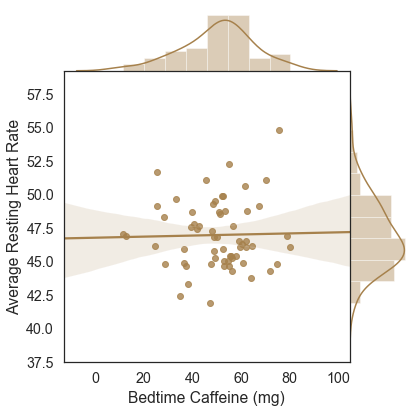

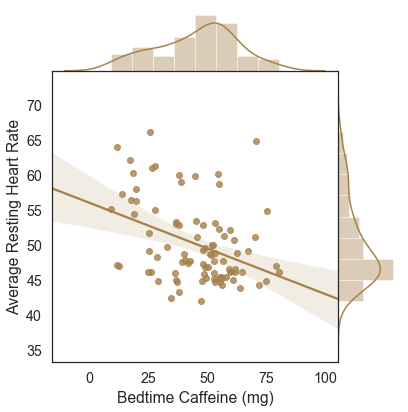

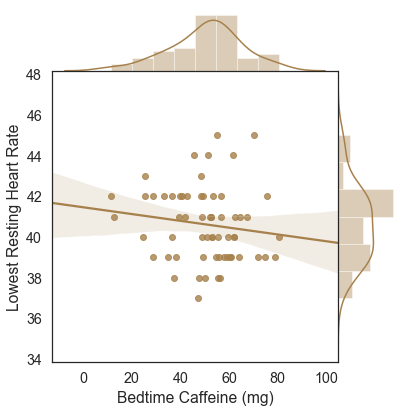

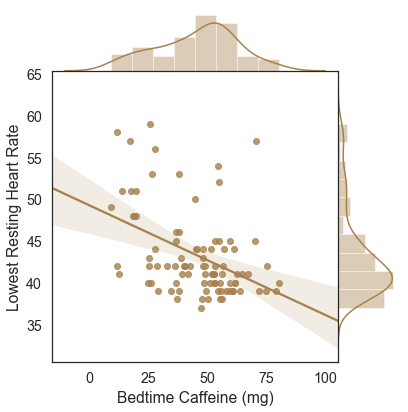

In [32]:
sns.set(font_scale=1.3)
with sns.axes_style("white"):
    sns.jointplot(data=dataframe_lowbooze, x='Bedtime Caffeine (mg)', y='Average Resting Heart Rate', kind='reg', color=sns.xkcd_rgb["coffee"], space=0)
    sns.jointplot(data=dataframe, x='Bedtime Caffeine (mg)', y='Average Resting Heart Rate', kind='reg', color=sns.xkcd_rgb["coffee"], space=0)
    sns.jointplot(data=dataframe_lowbooze, x='Bedtime Caffeine (mg)', y='Lowest Resting Heart Rate', kind='reg', color=sns.xkcd_rgb["coffee"], space=0)
    sns.jointplot(data=dataframe, x='Bedtime Caffeine (mg)', y='Lowest Resting Heart Rate', kind='reg', color=sns.xkcd_rgb["coffee"], space=0)

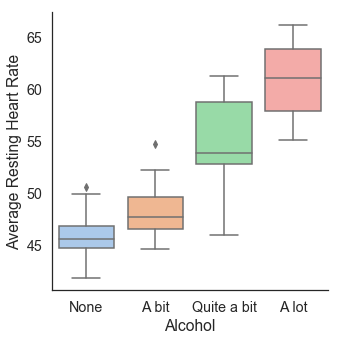

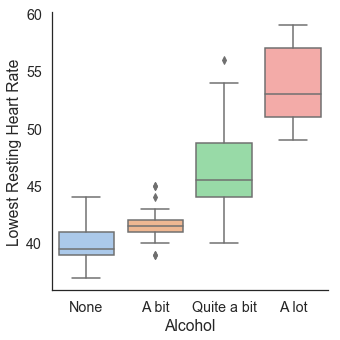

In [23]:
with sns.axes_style("white"):
    ax = sns.catplot(x="Alcohol", y="Average Resting Heart Rate", kind="box", data=dataframe, palette="pastel")
    ax = sns.catplot(x="Alcohol", y="Lowest Resting Heart Rate", kind="box", data=dataframe, palette="pastel")

/Users/maxfrenzel/py3.6/lib/python3.6/site-packages/numpy/lib/function_base.py:838: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/Users/maxfrenzel/py3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/maxfrenzel/py3.6/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/maxfrenzel/py3.6/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


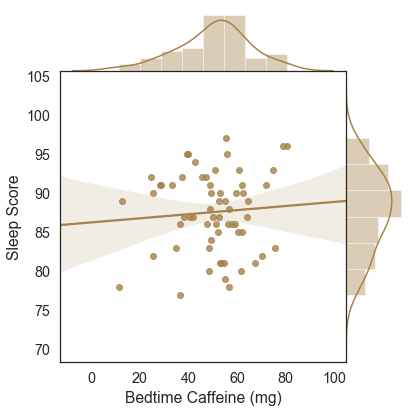

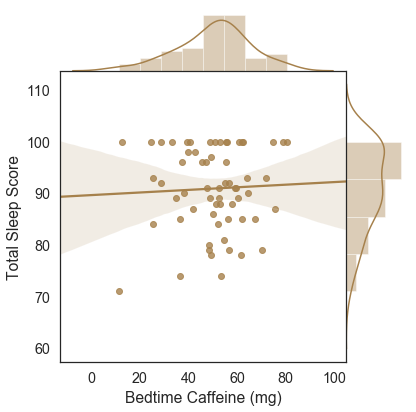

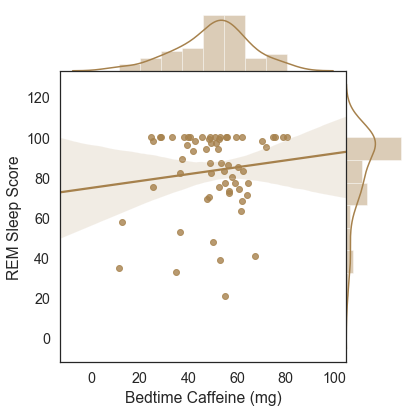

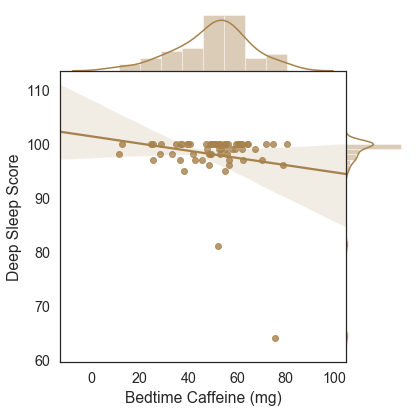

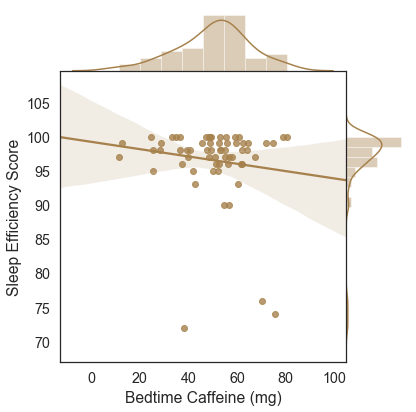

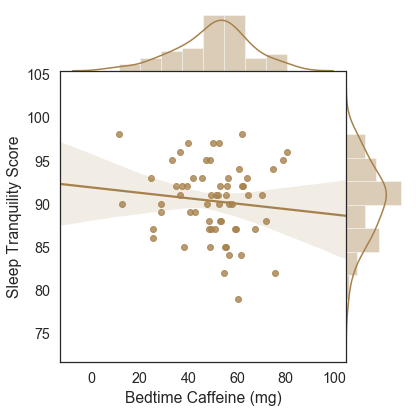

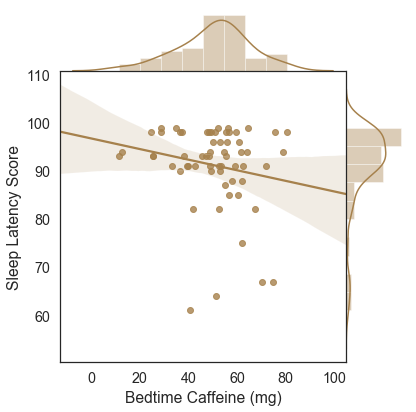

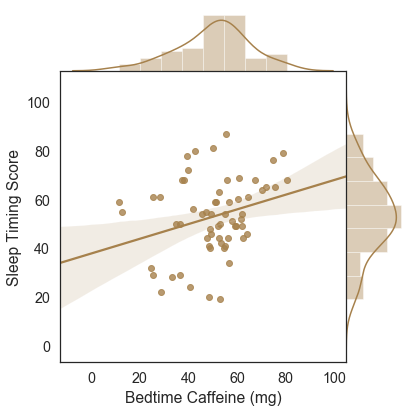

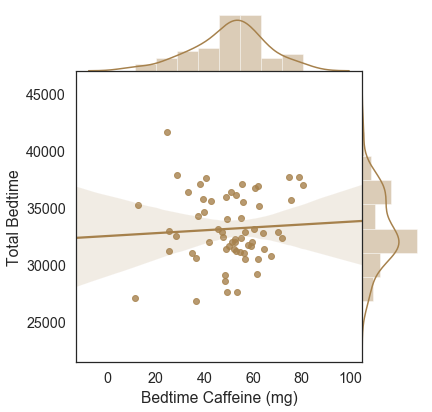

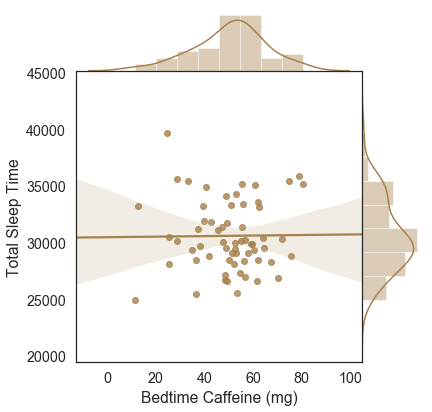

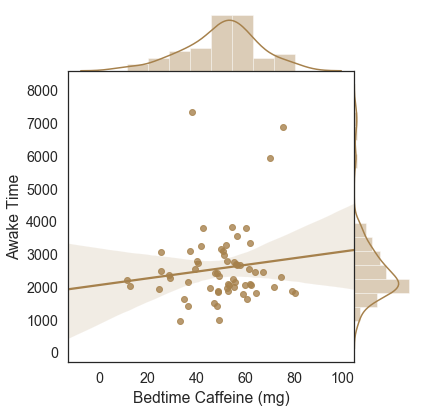

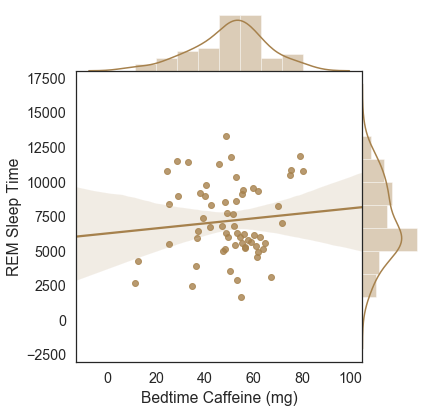

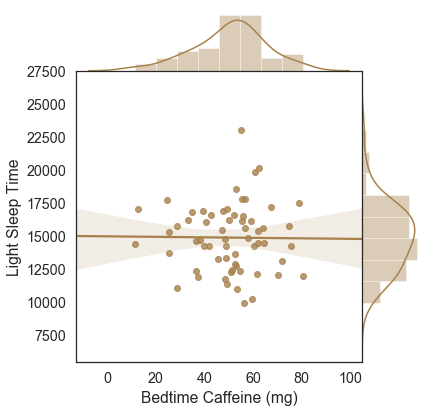

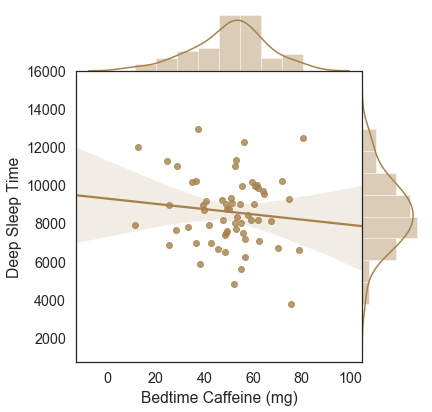

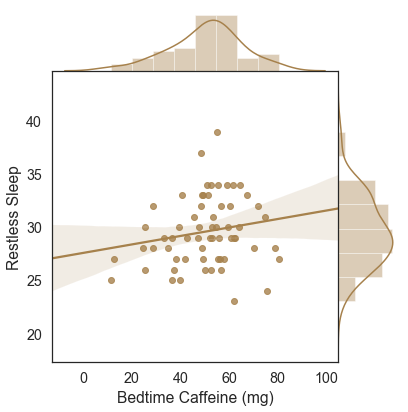

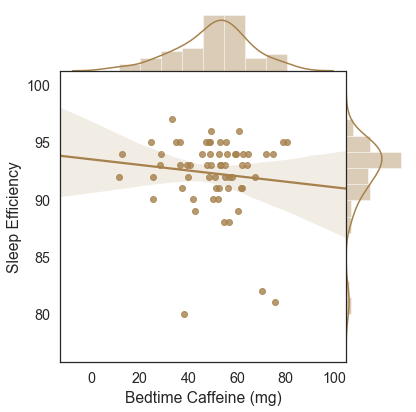

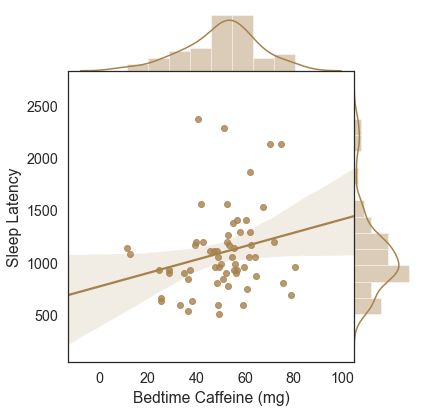

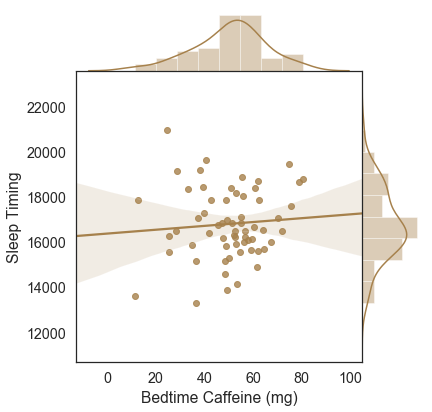

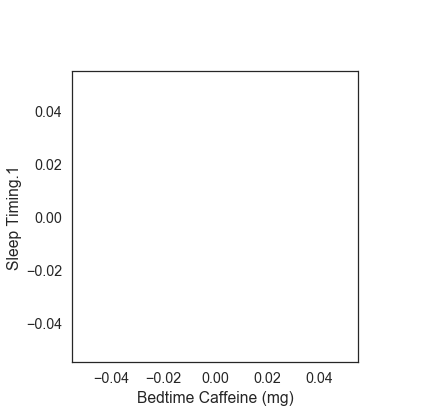

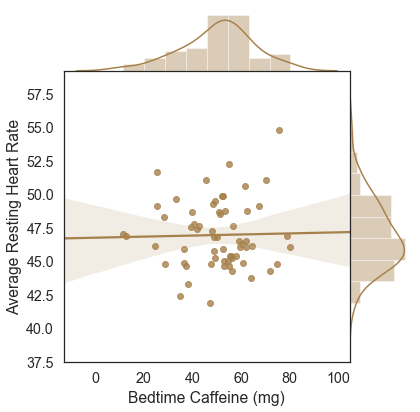

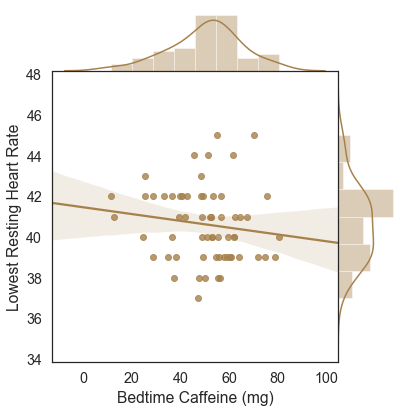

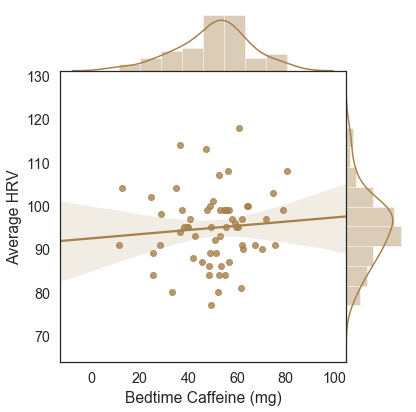

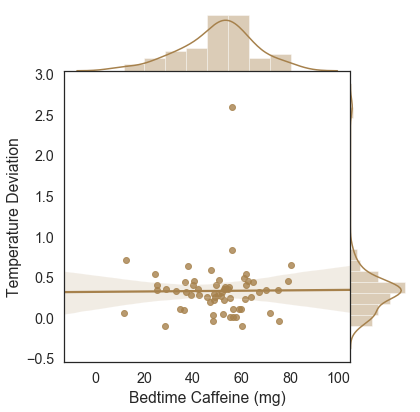

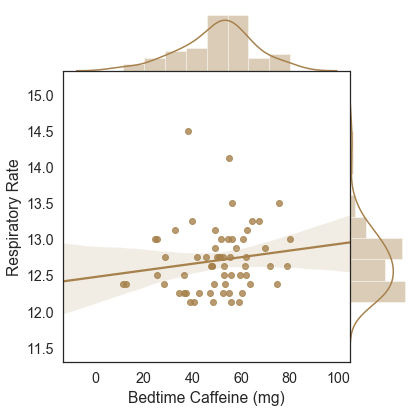

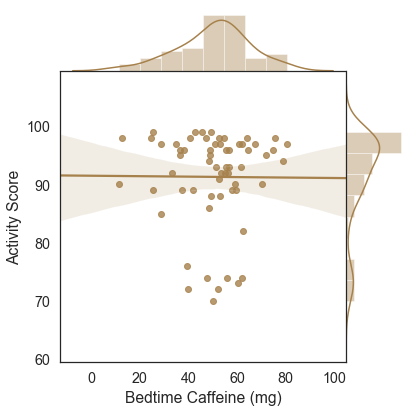

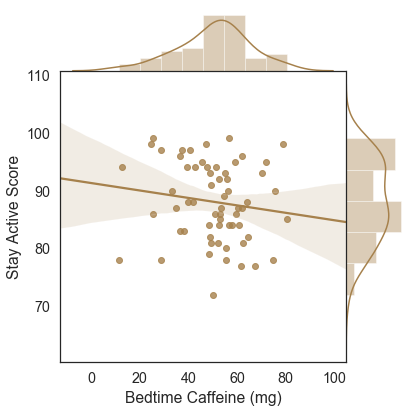

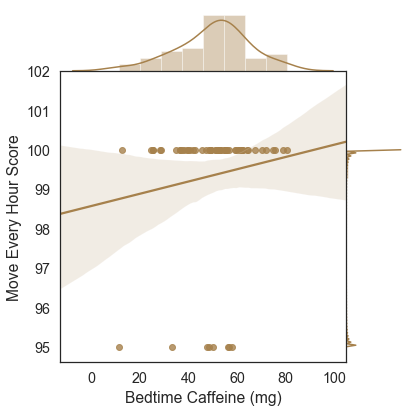

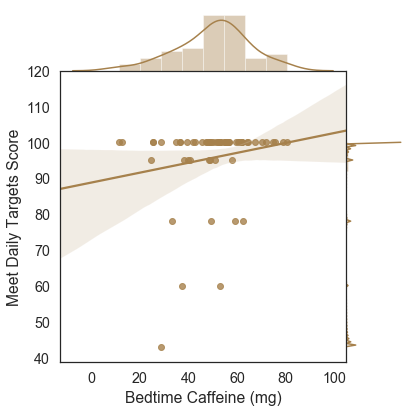

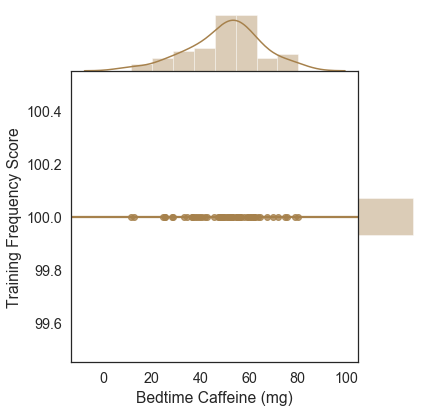

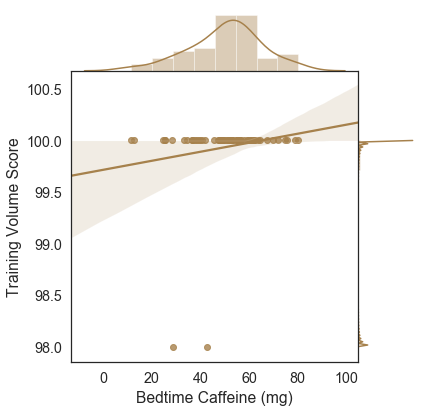

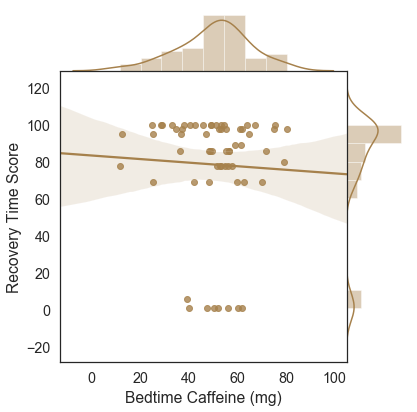

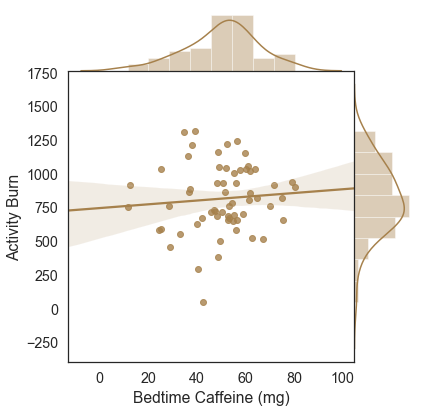

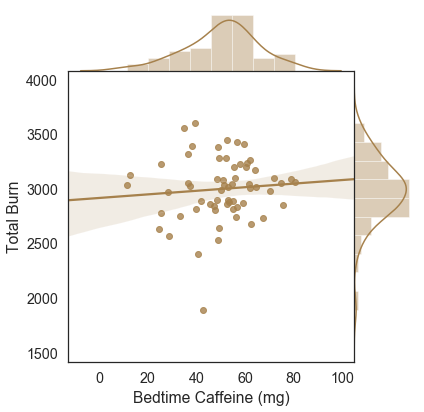

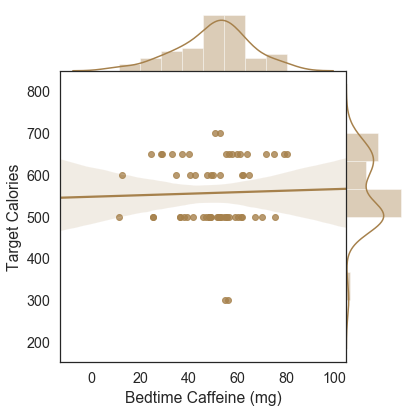

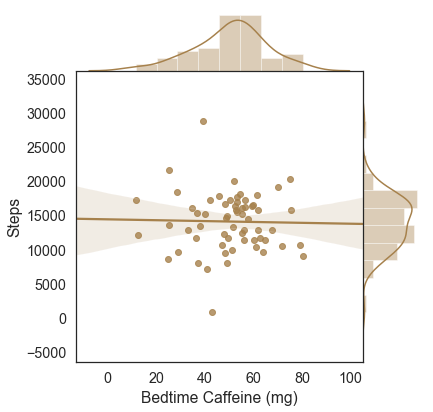

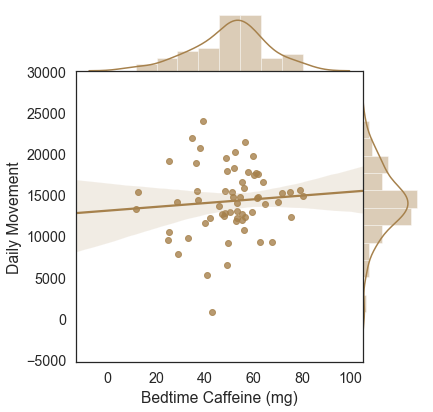

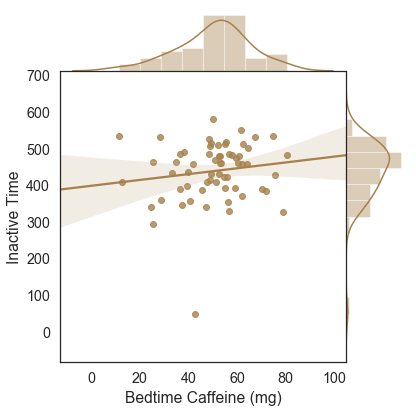

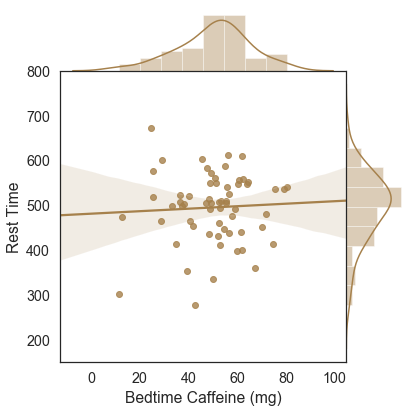

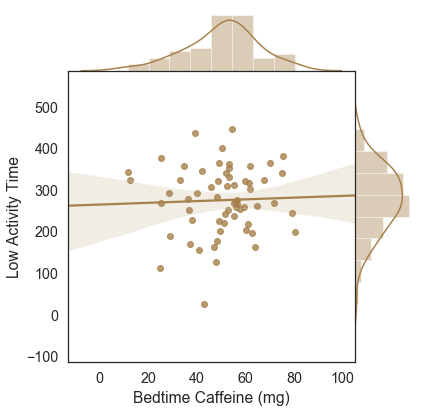

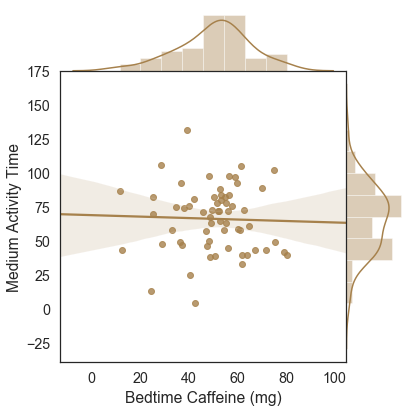

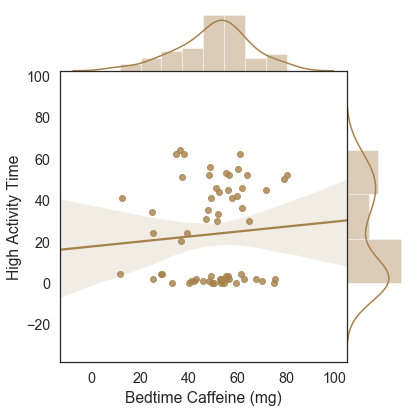

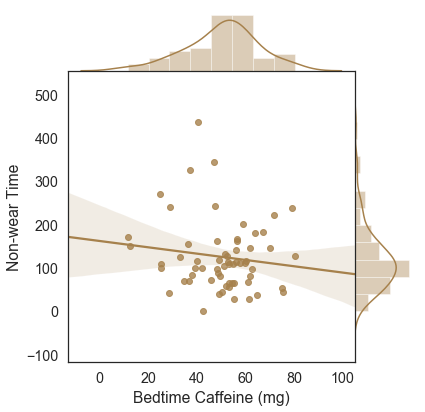

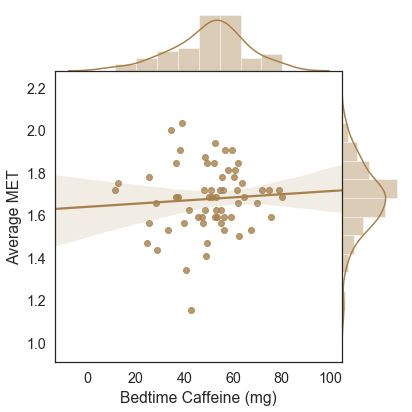

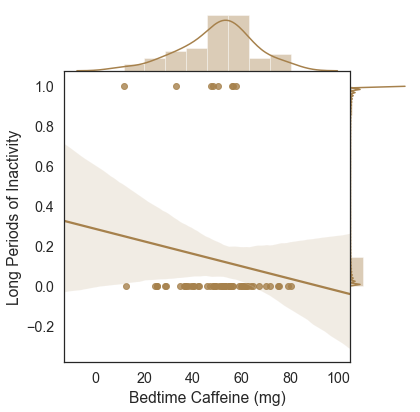

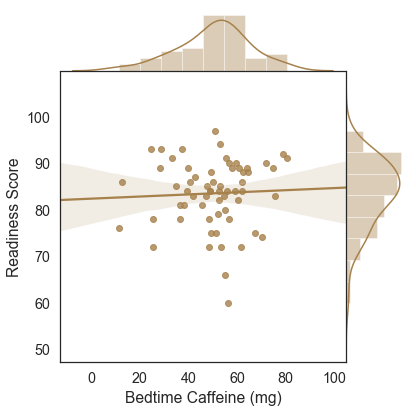

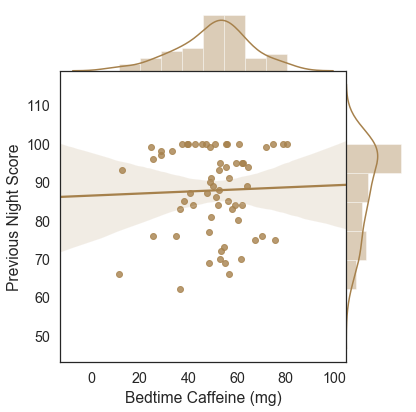

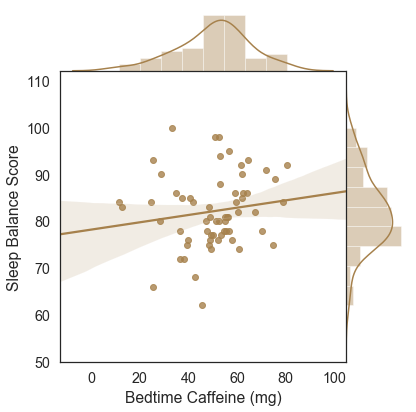

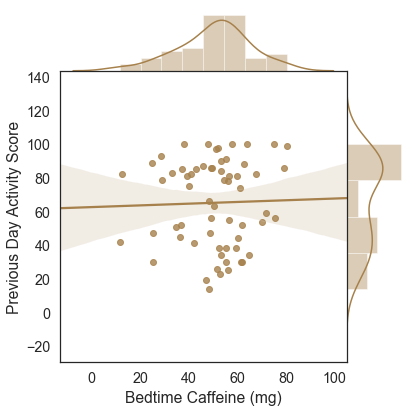

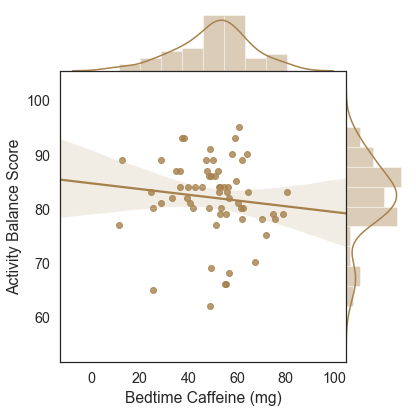

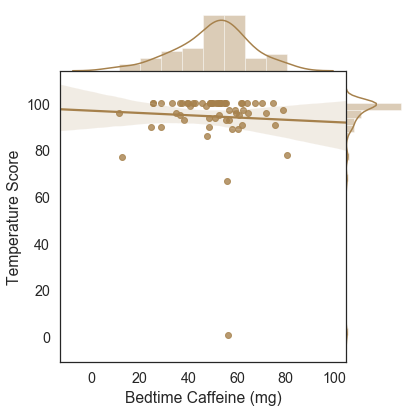

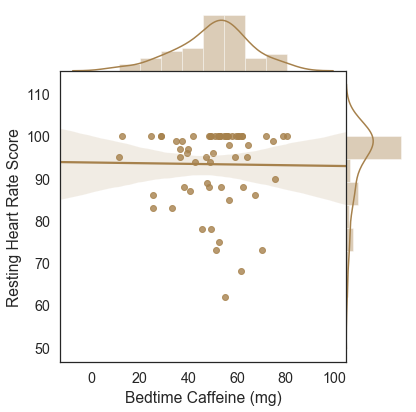

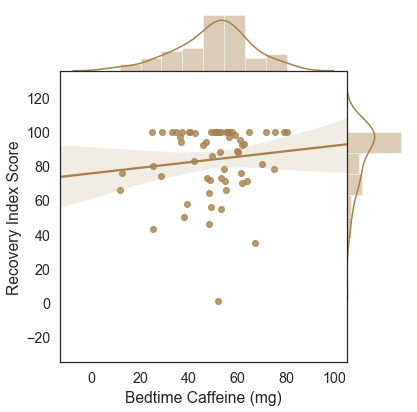

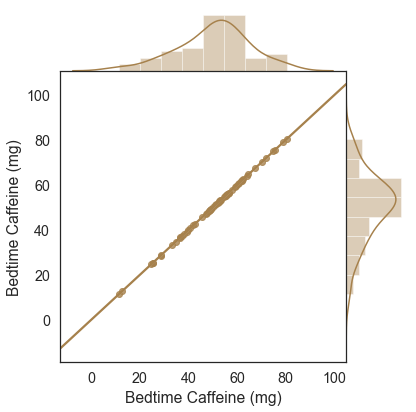

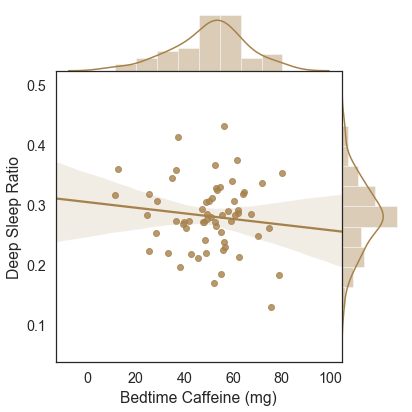

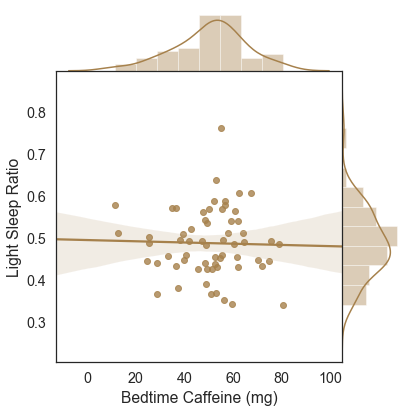

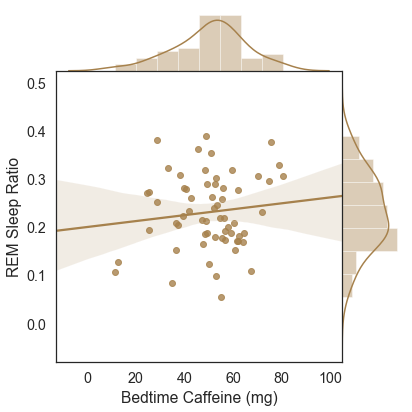

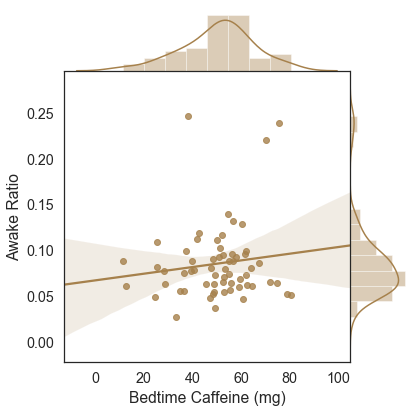

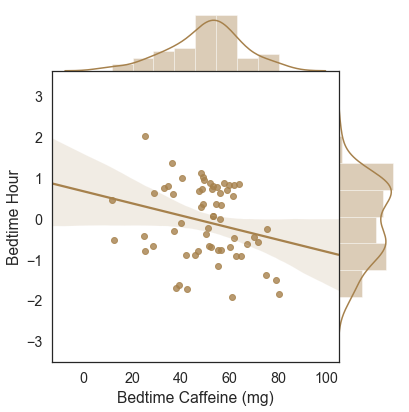

In [31]:
with sns.axes_style("white"):
    for col in list(dataframe):
        if dataframe[col].dtype in (float64, int64):
            try:
                sns.jointplot(data=dataframe_lowbooze, x='Bedtime Caffeine (mg)', y=col, kind='reg', color=sns.xkcd_rgb["coffee"], space=0)
            except:
                pass

/Users/maxfrenzel/py3.6/lib/python3.6/site-packages/numpy/lib/function_base.py:838: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/Users/maxfrenzel/py3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/maxfrenzel/py3.6/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/maxfrenzel/py3.6/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


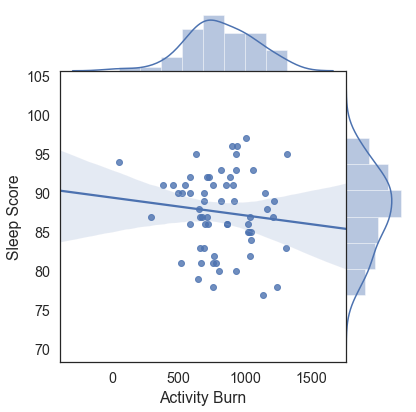

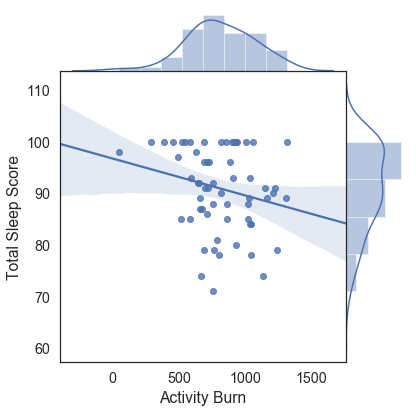

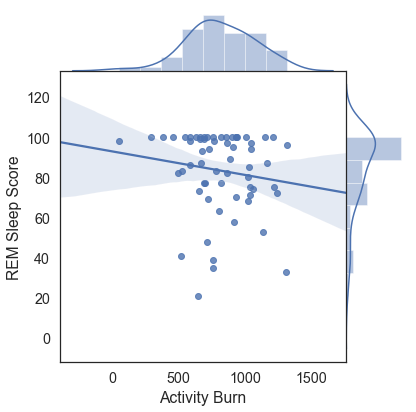

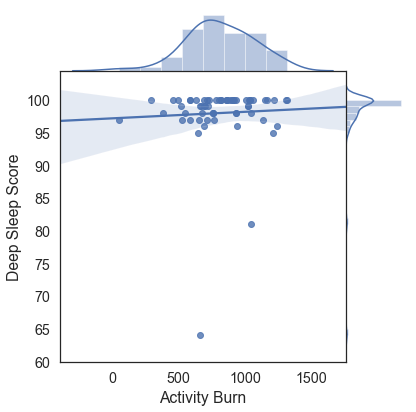

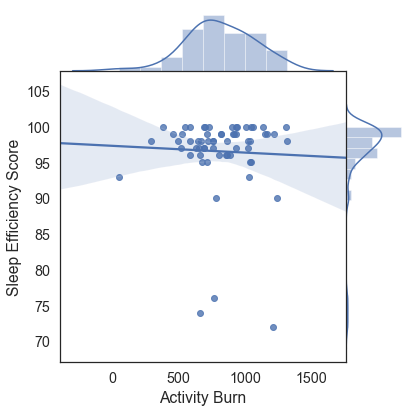

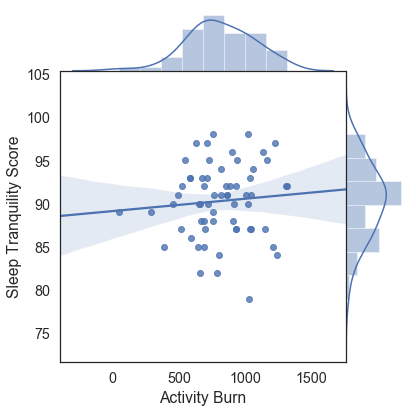

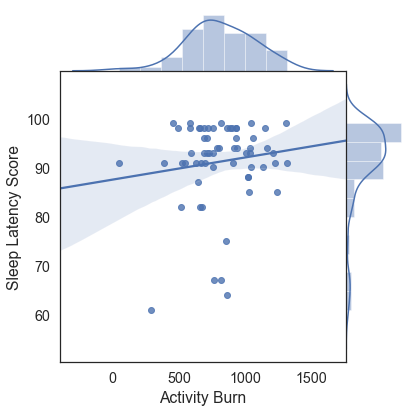

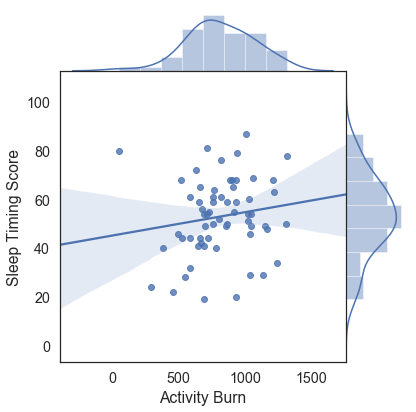

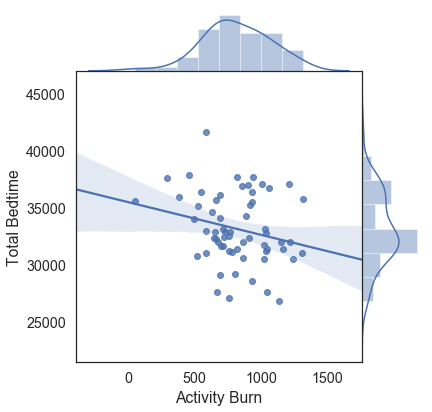

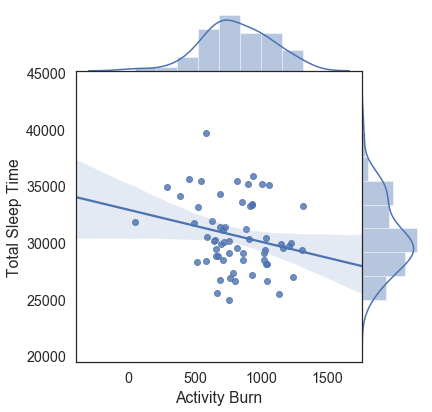

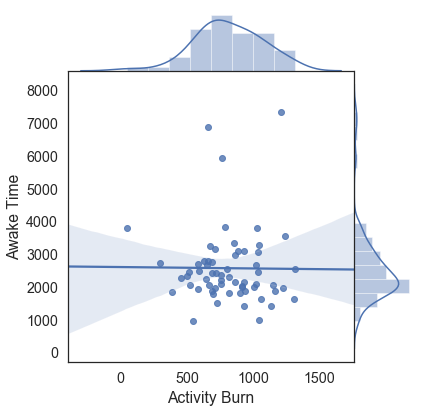

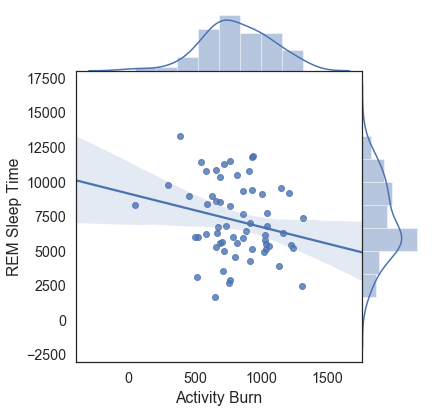

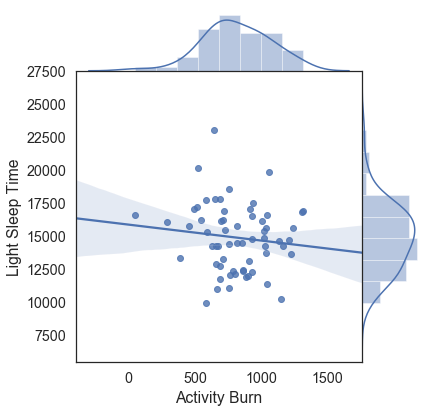

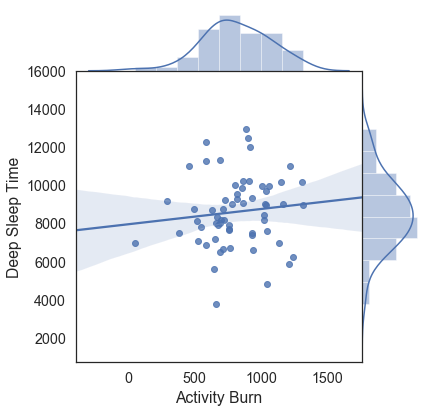

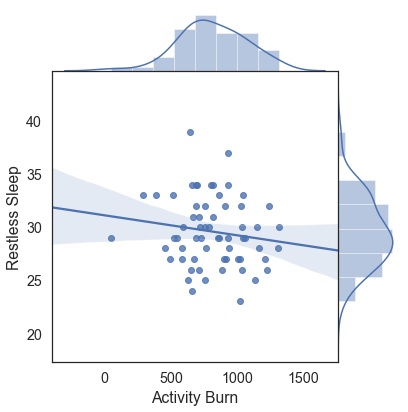

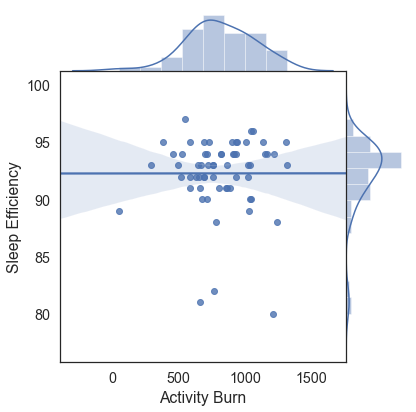

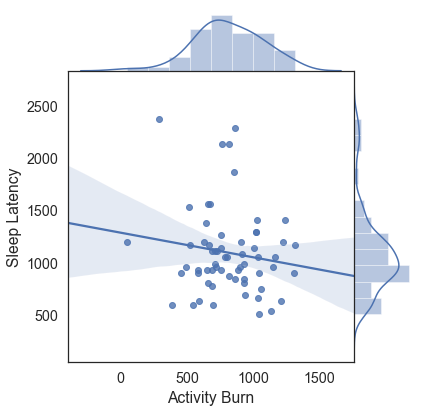

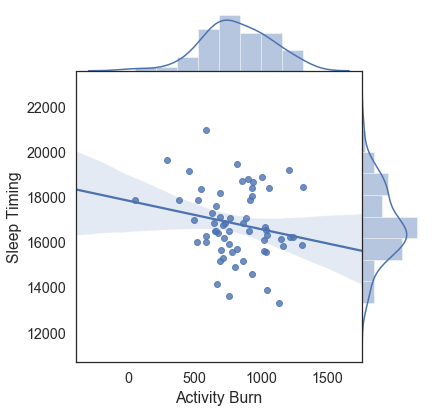

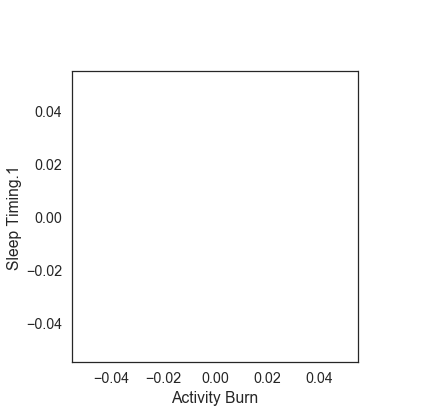

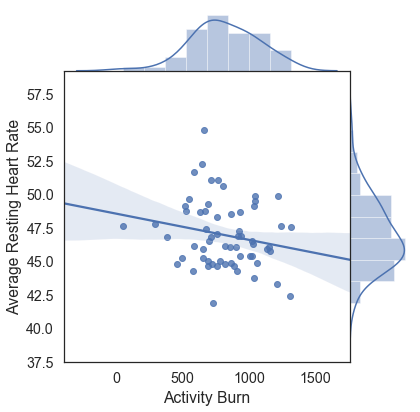

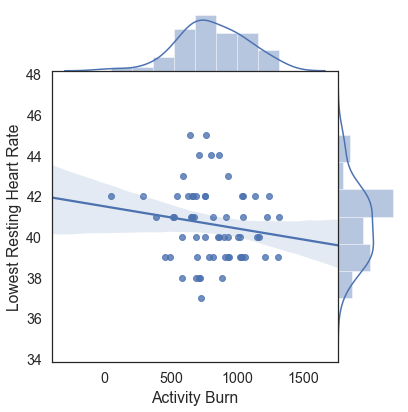

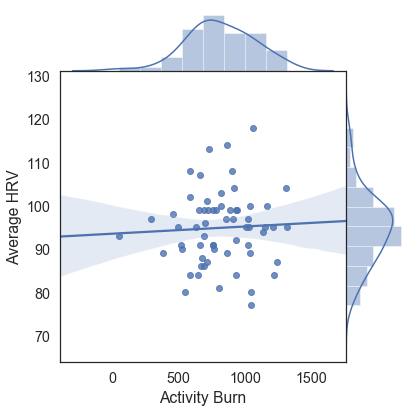

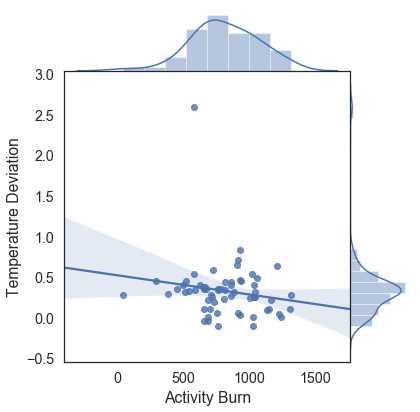

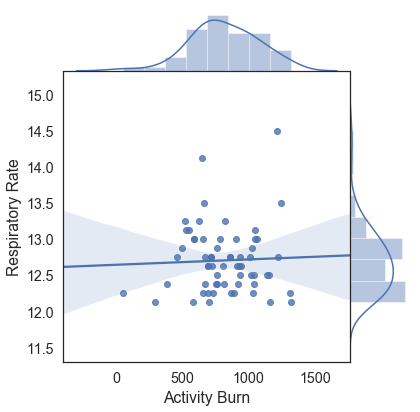

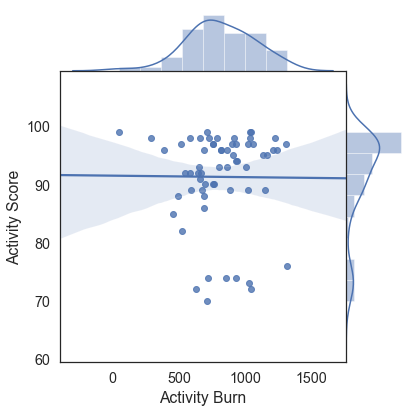

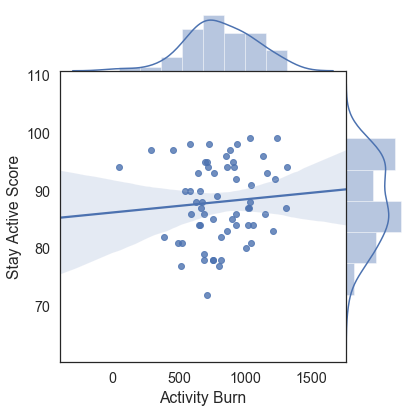

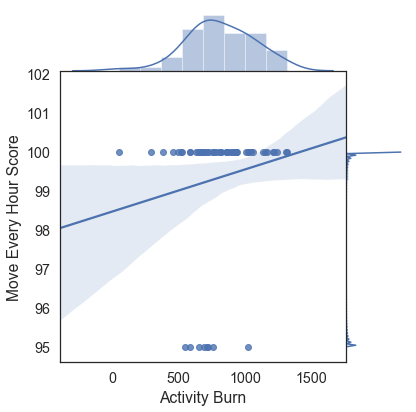

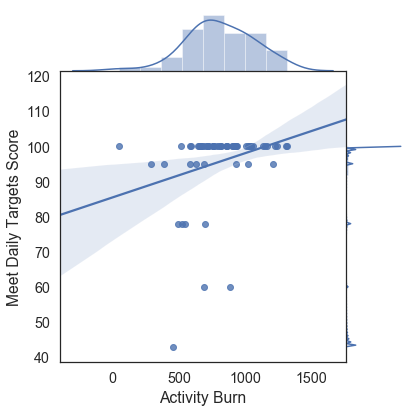

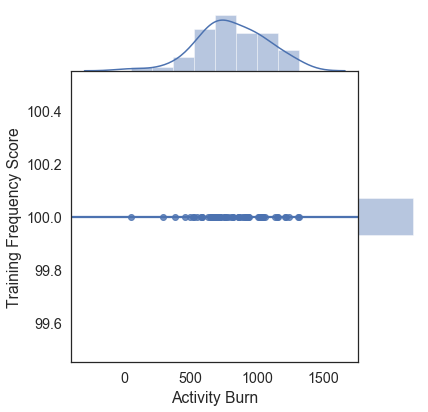

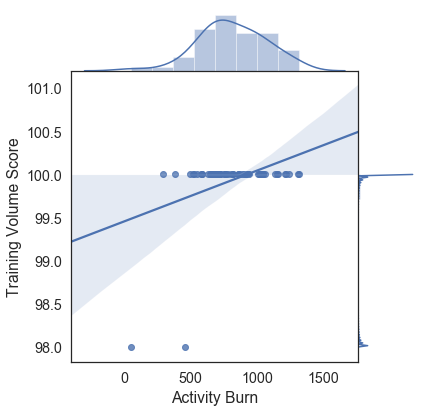

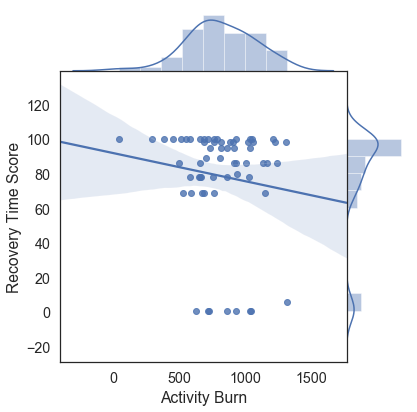

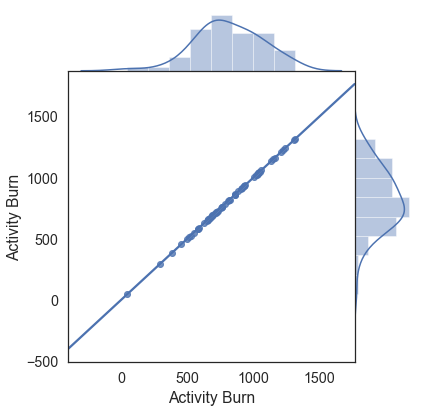

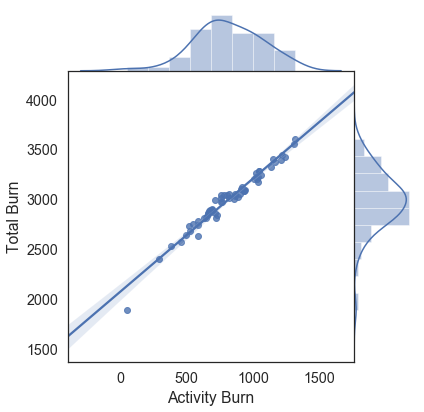

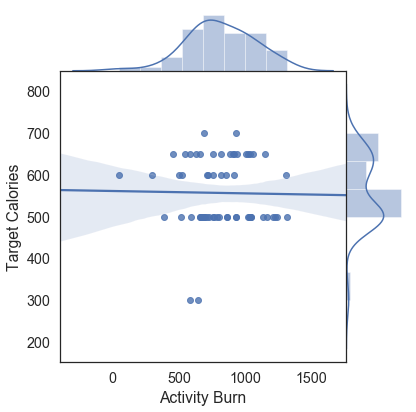

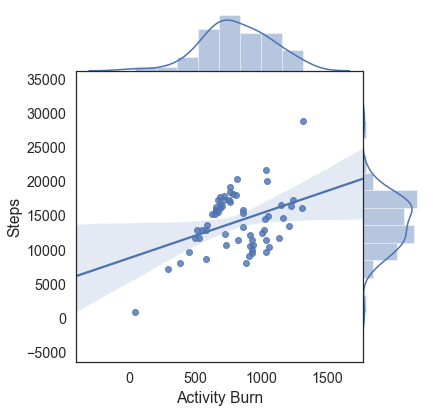

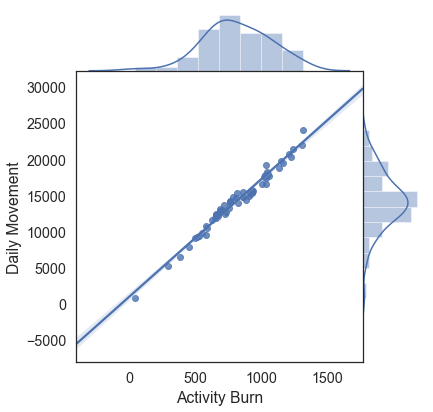

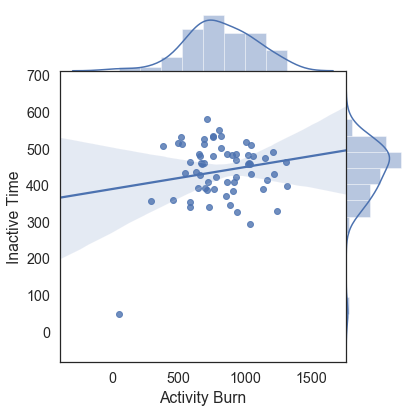

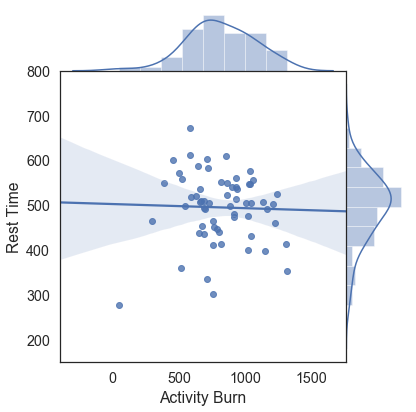

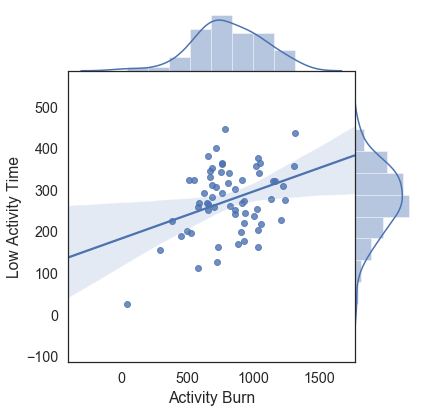

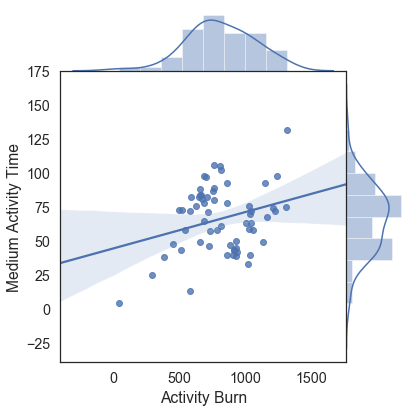

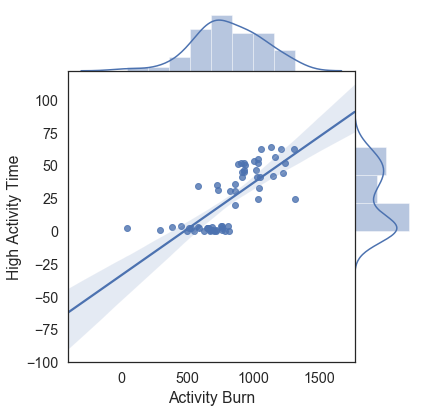

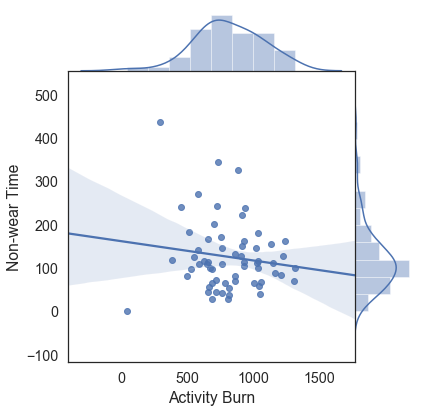

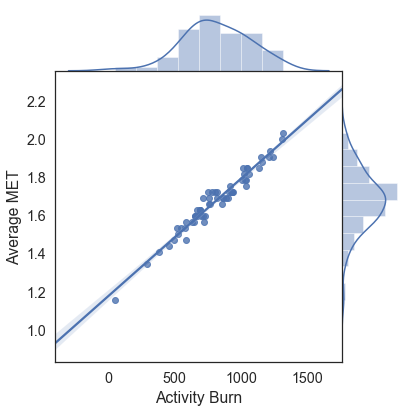

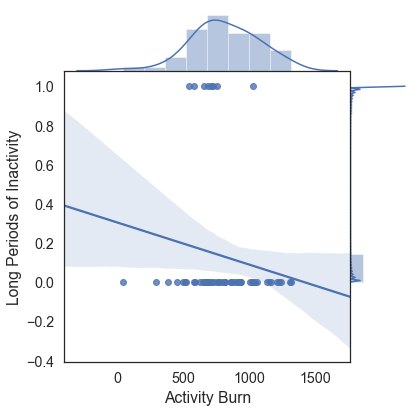

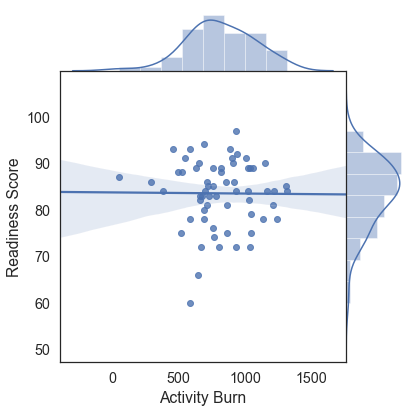

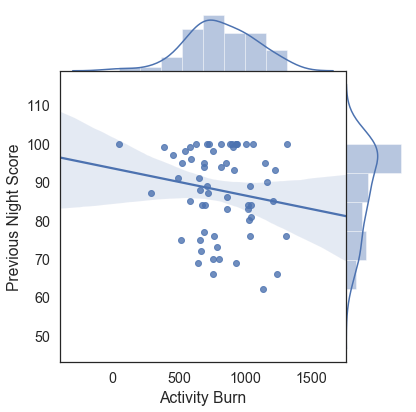

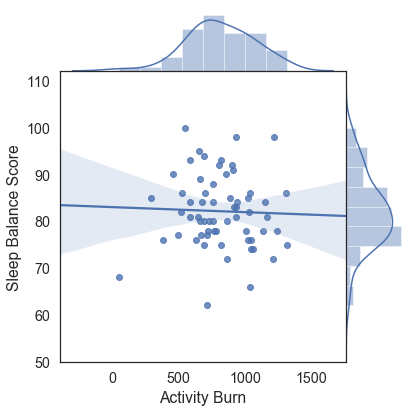

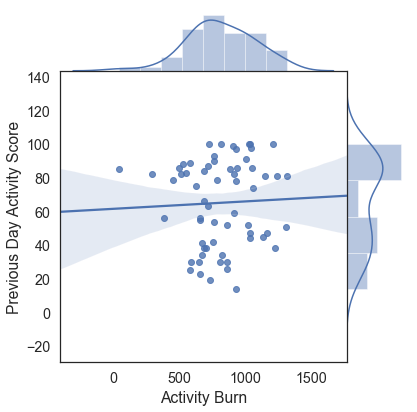

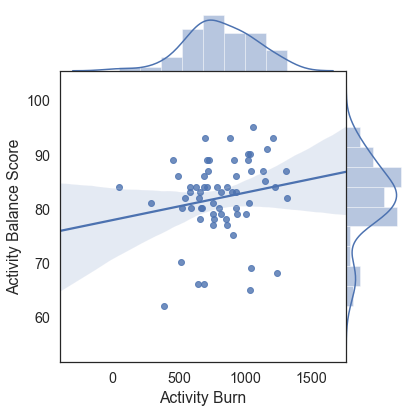

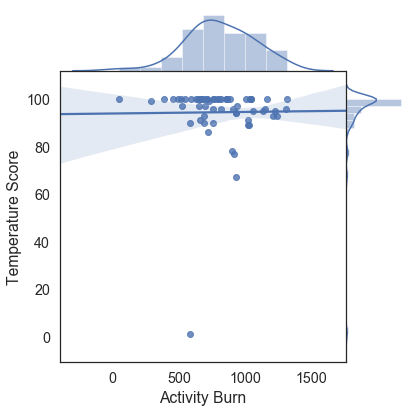

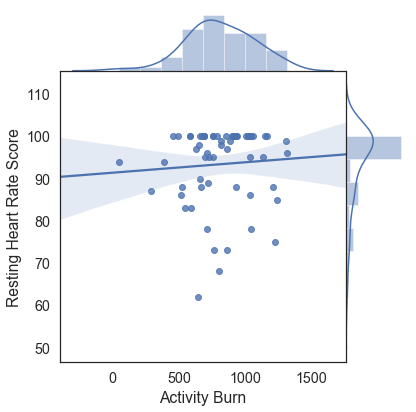

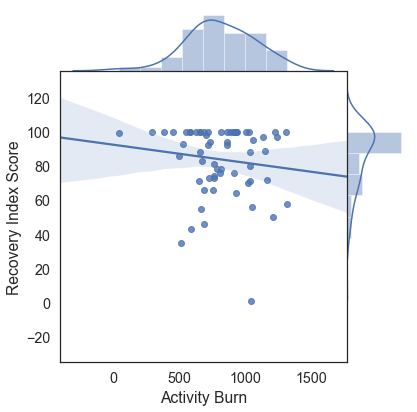

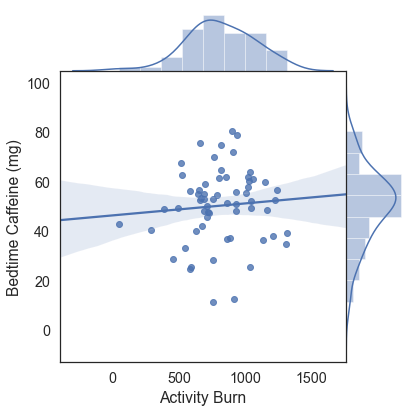

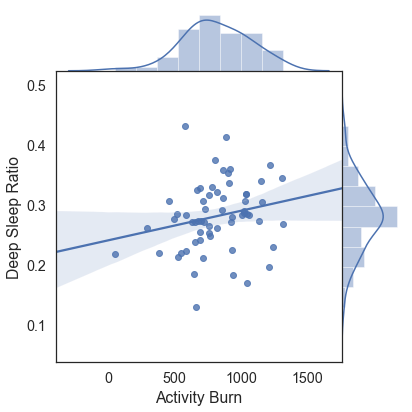

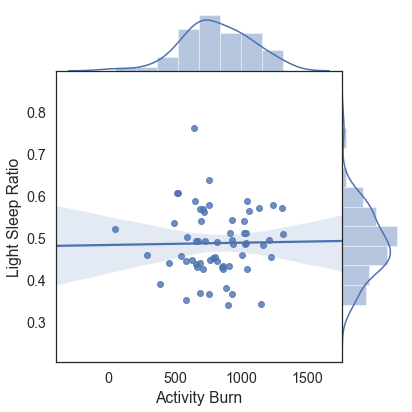

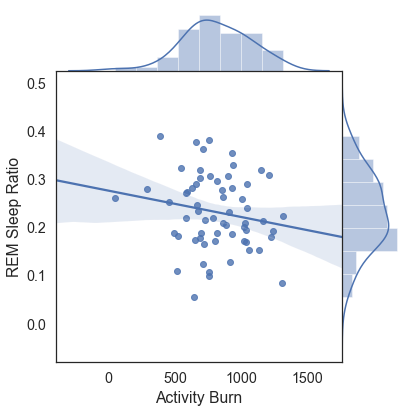

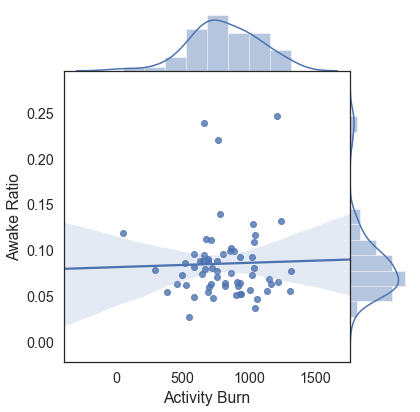

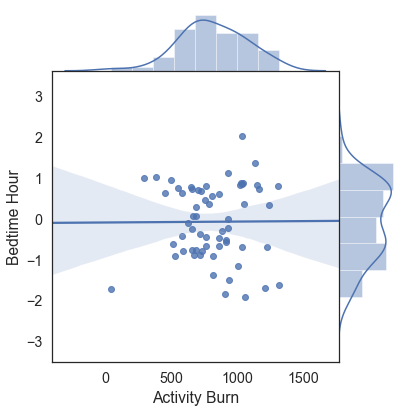

In [33]:
with sns.axes_style("white"):
    for col in list(dataframe):
        if dataframe[col].dtype in (float64, int64):
            try:
                sns.jointplot(data=dataframe_lowbooze, x='Activity Burn', y=col, kind='reg', color='b', space=0)
            except:
                pass

/Users/maxfrenzel/py3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


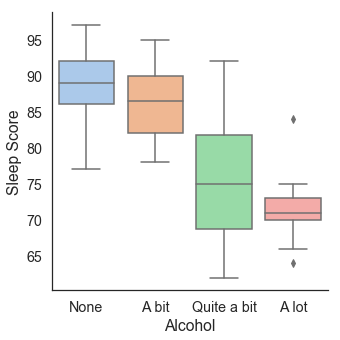

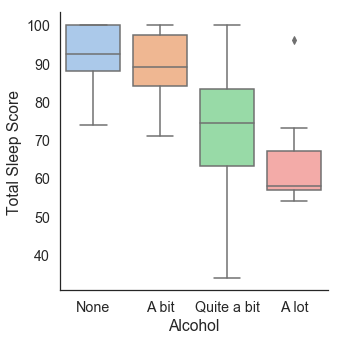

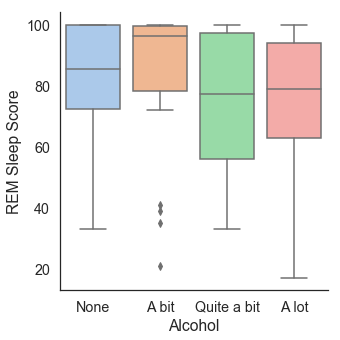

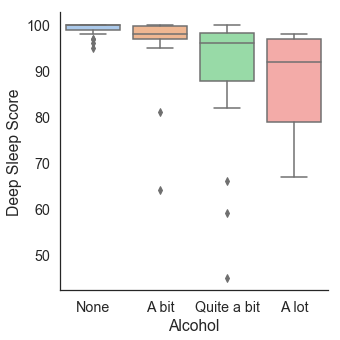

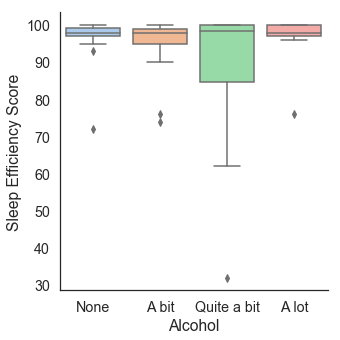

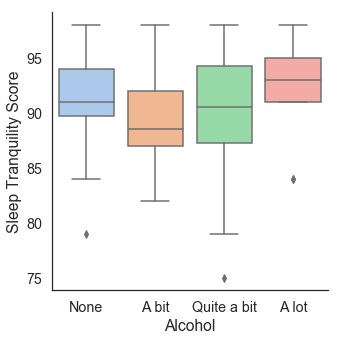

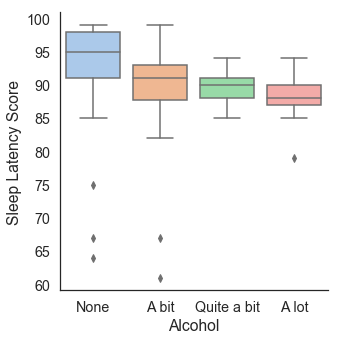

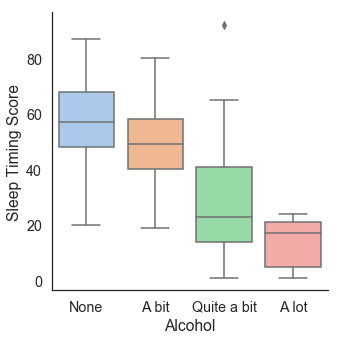

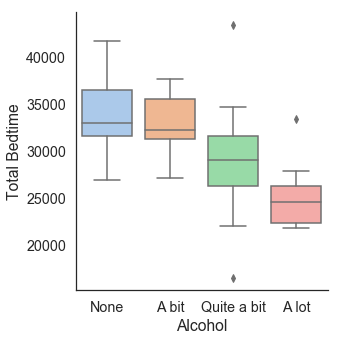

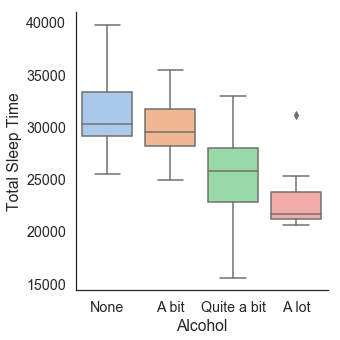

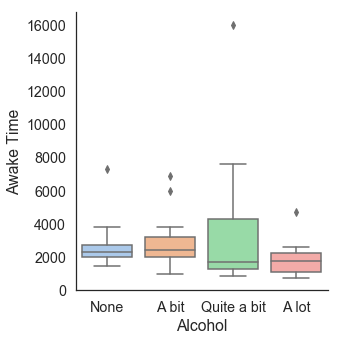

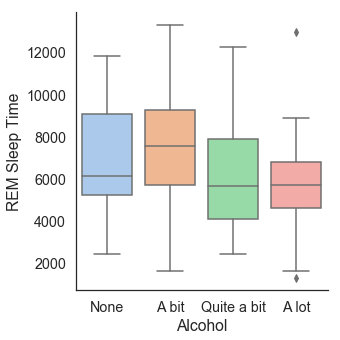

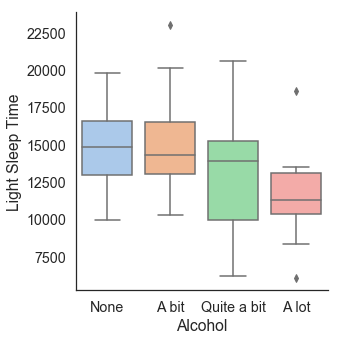

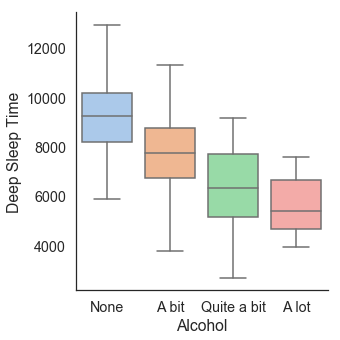

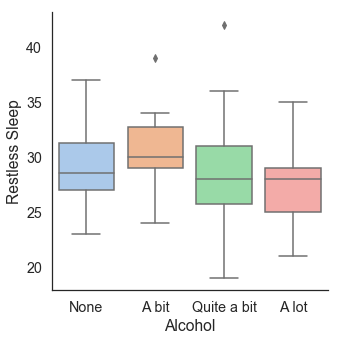

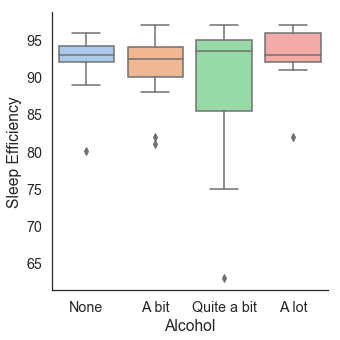

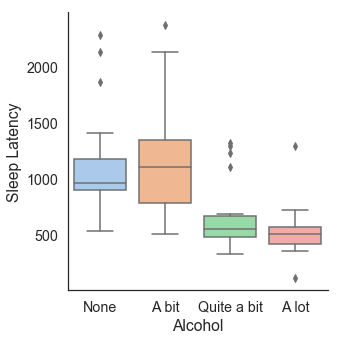

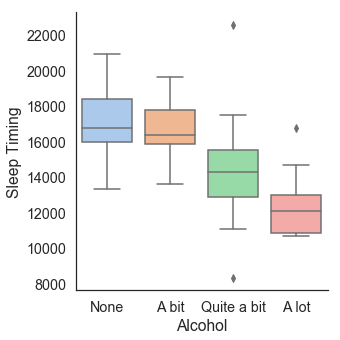

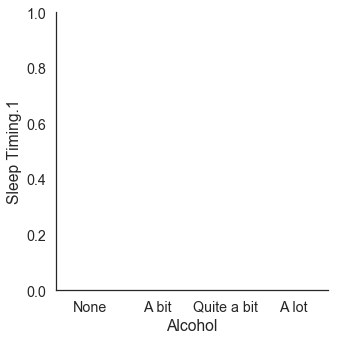

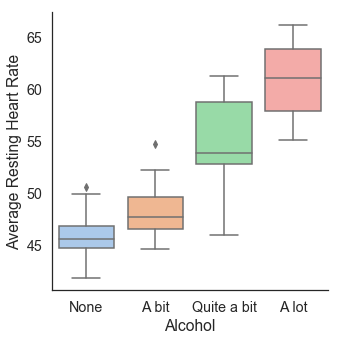

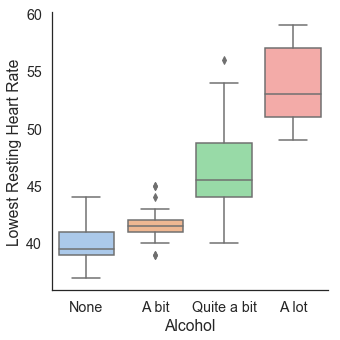

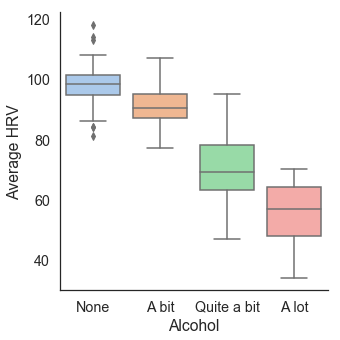

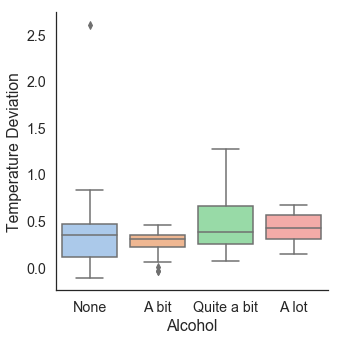

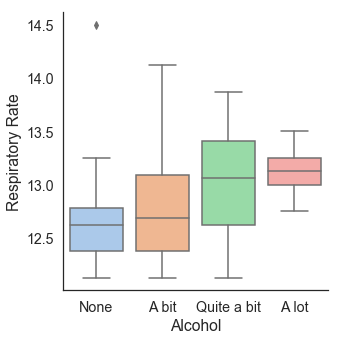

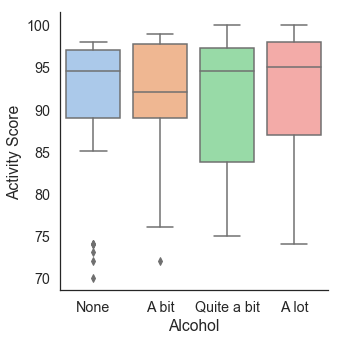

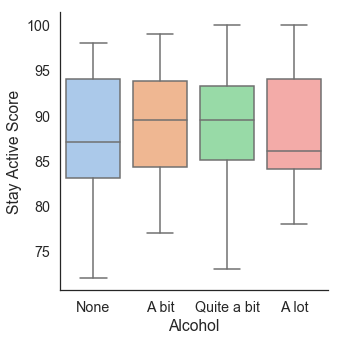

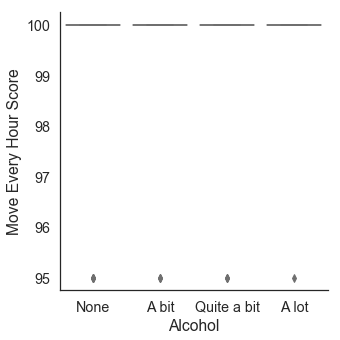

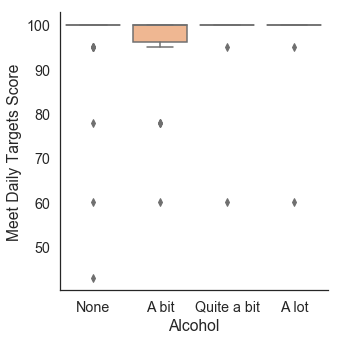

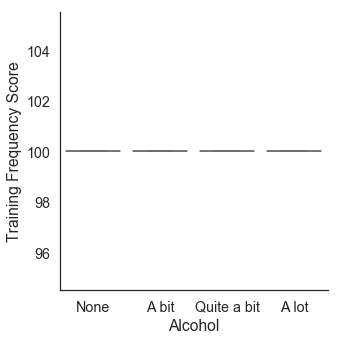

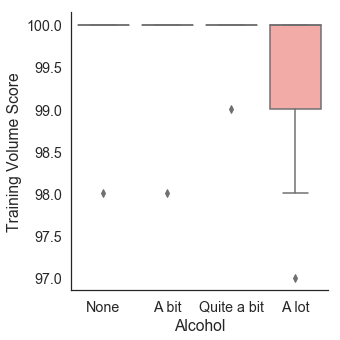

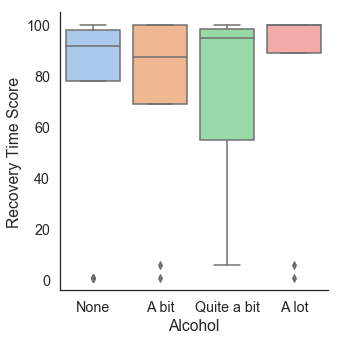

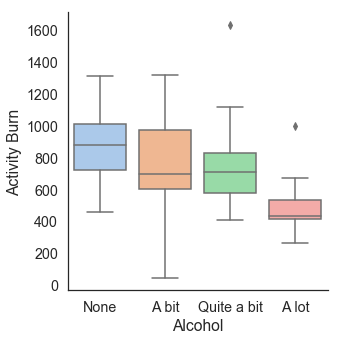

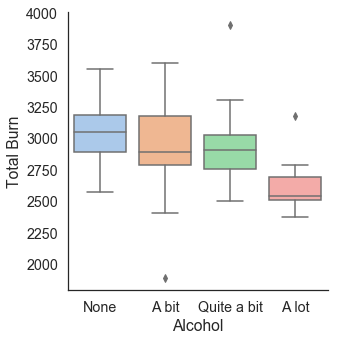

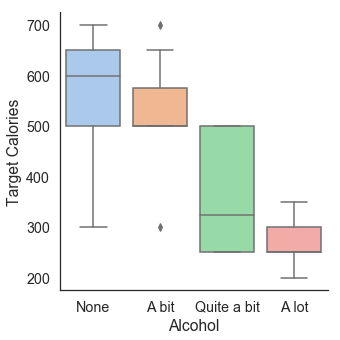

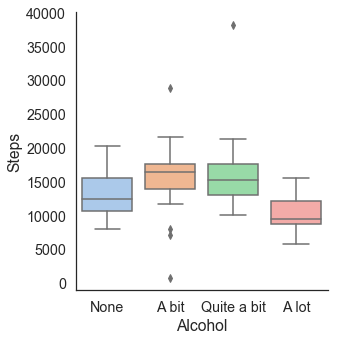

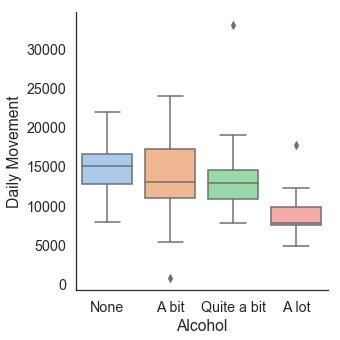

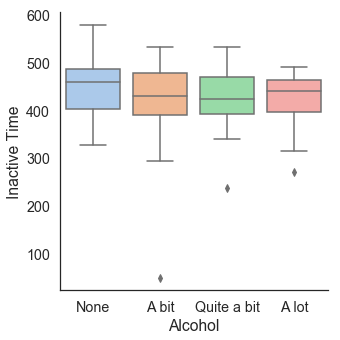

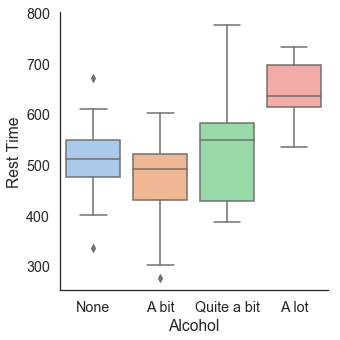

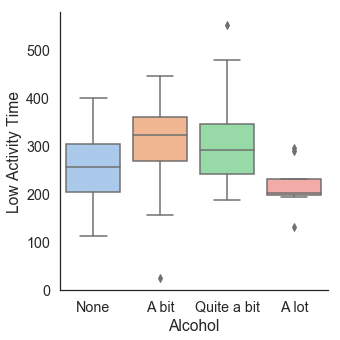

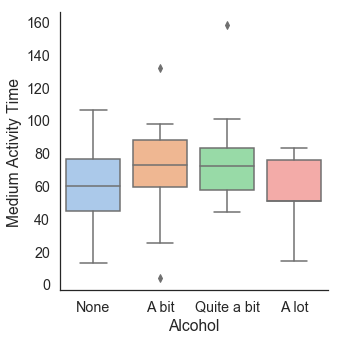

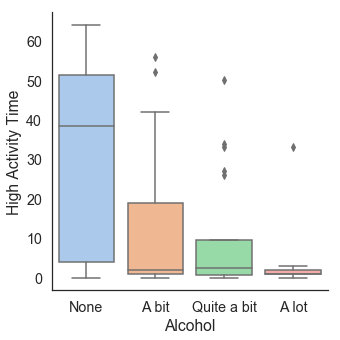

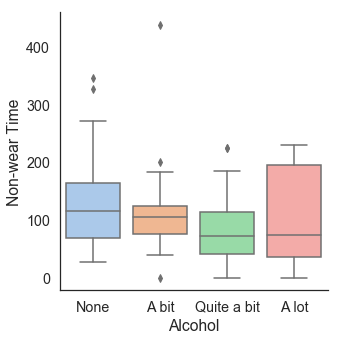

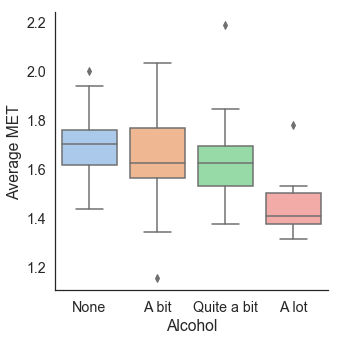

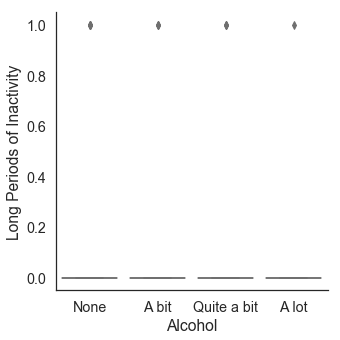

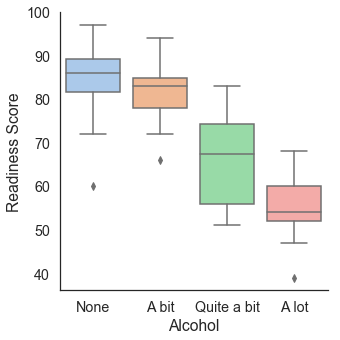

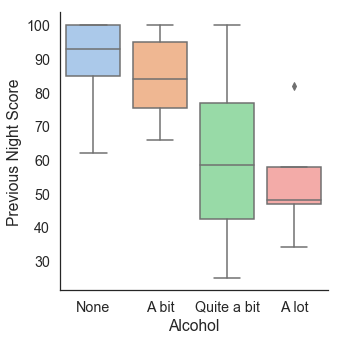

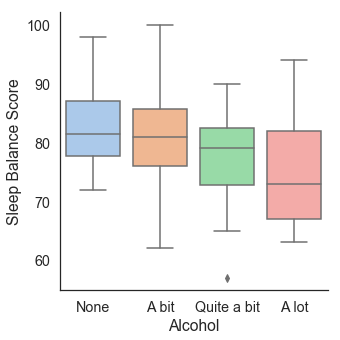

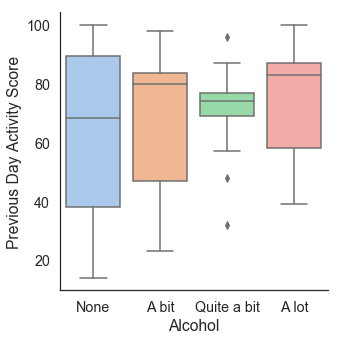

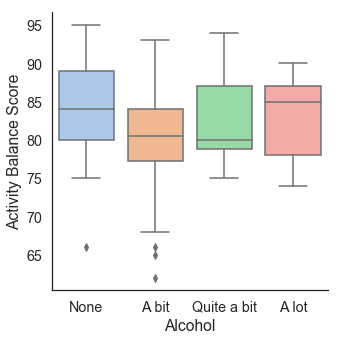

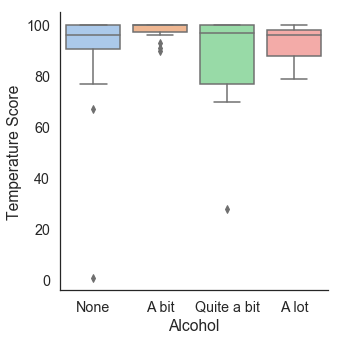

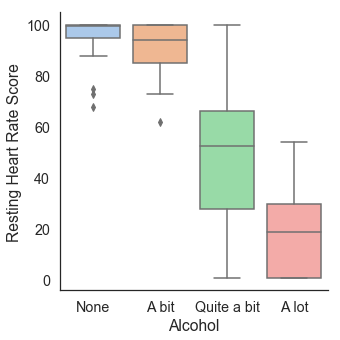

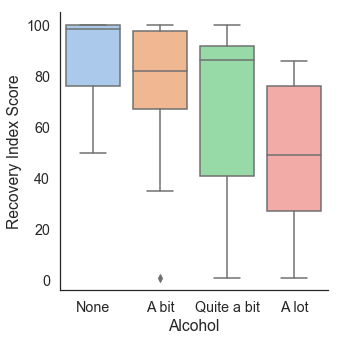

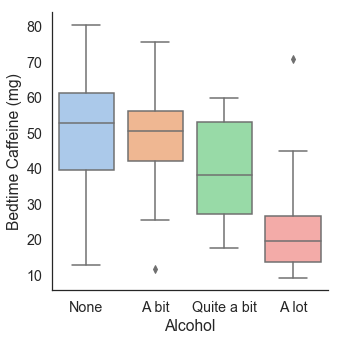

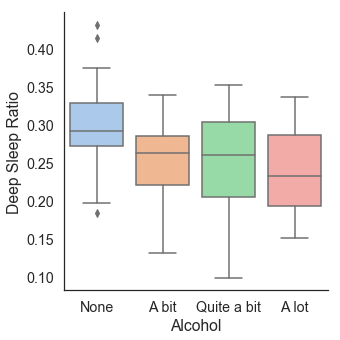

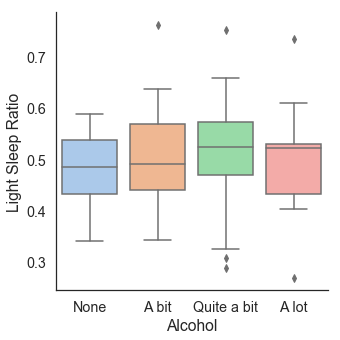

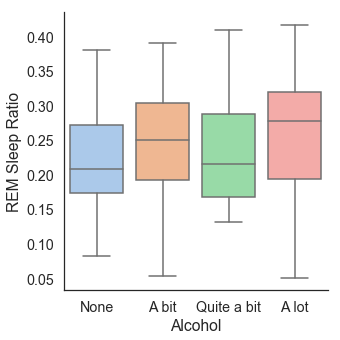

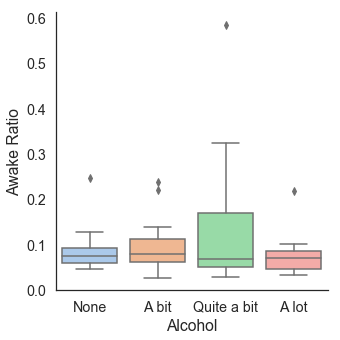

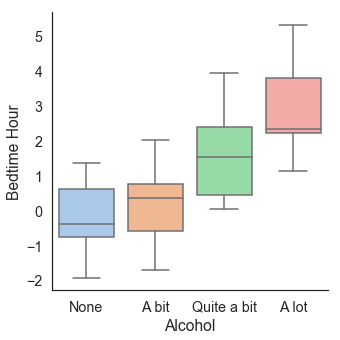

In [34]:
with sns.axes_style("white"):
    for col in list(dataframe):
        if dataframe[col].dtype in (float64, int64):
            try:
                sns.catplot(x="Alcohol", y=col, kind="box", data=dataframe, palette="pastel")
            except:
                pass